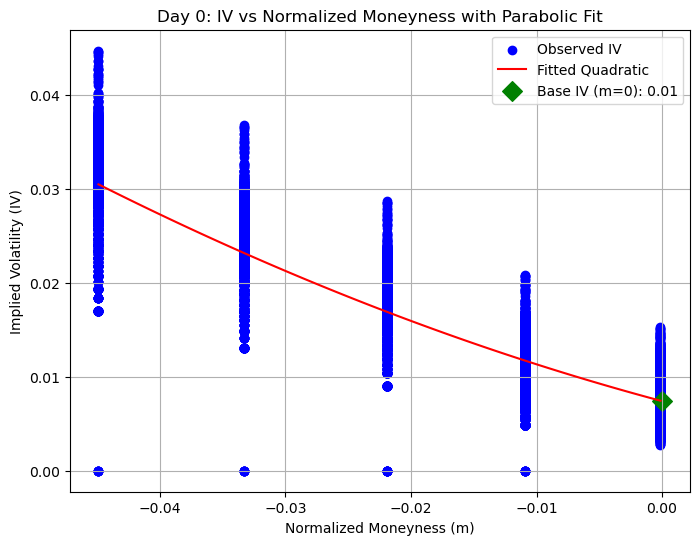

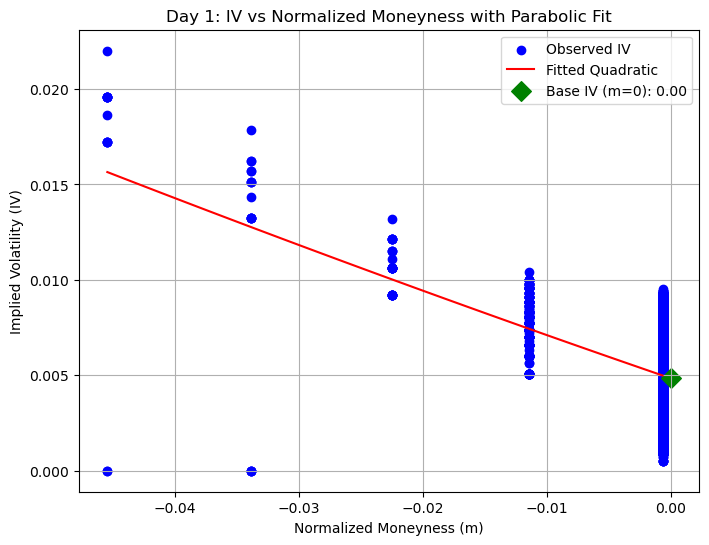

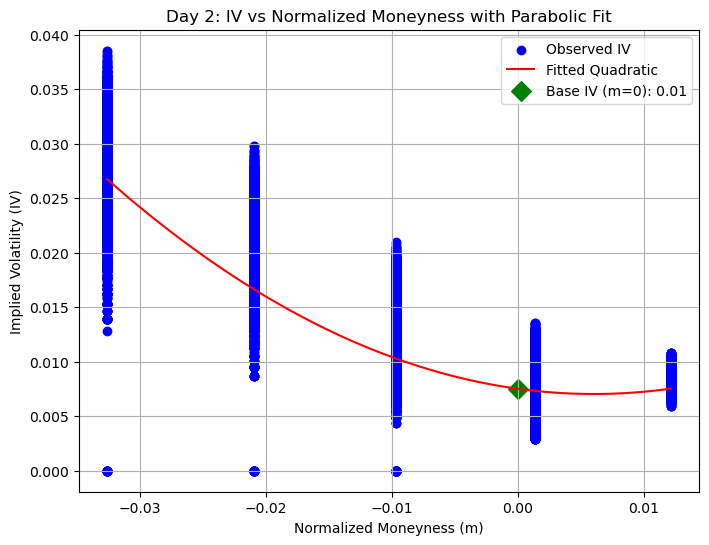

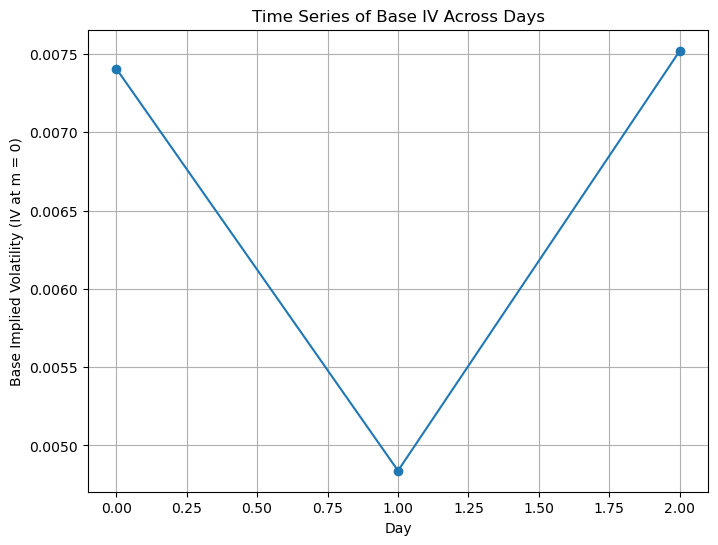

In [6]:
import pandas as pd
import numpy as np
import math
from scipy import stats, optimize
import matplotlib.pyplot as plt

# === Utility Functions ===

# Black-Scholes call price (assumes zero risk-free rate)
def bs_call_price(S, K, T, sigma, r=0.0):
    d1 = (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

# Implied volatility finder using Brent's method.
def implied_vol(S, K, T, market_price, r=0.0):
    def f(sigma):
        return bs_call_price(S, K, T, sigma, r) - market_price
    try:
        vol = optimize.brentq(f, 1e-6, 5.0)
    except Exception:
        vol = np.nan
    return vol

# Black-Scholes vega (sensitivity of option price to volatility)
def bs_vega(S, K, T, sigma, r=0.0):
    d1 = (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    return S * np.sqrt(T) * stats.norm.pdf(d1)

# === Load Data ===

# List the CSV filenames (ensure paths are correct)
files = [
    "prices_round_3_day_0.csv",
    "prices_round_3_day_1.csv",
    "prices_round_3_day_2.csv"
]

# Load CSV files (using ';' as delimiter) and add a "day" indicator.
dfs = []
for i, file in enumerate(files):
    df = pd.read_csv("" + file, delimiter=';')
    df["day"] = i  # Tag each file with the corresponding day number.
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True)

# --- Extract Underlying Price ---

# Rows where product == "VOLCANIC_ROCK" contain the underlying price.
# We use the mid_price column as S.
underlying_df = data[data["product"] == "VOLCANIC_ROCK"][["day", "mid_price"]].rename(columns={"mid_price": "S"})

# If there are multiple underlying rows per day, take one (e.g., the first occurrence).
underlying_df = underlying_df.drop_duplicates(subset="day")

# --- Filter for Voucher Data ---

# Voucher rows: those where the product name starts with "VOLCANIC_ROCK_VOUCHER"
voucher_data = data[data["product"].str.startswith("VOLCANIC_ROCK_VOUCHER")].copy()

# Merge the voucher rows with the underlying price (by day)
voucher_data = voucher_data.merge(underlying_df, on="day", how="left")

# Define voucher strike prices (update if needed)
voucher_strikes = {
    "VOLCANIC_ROCK_VOUCHER_9500": 9500,
    "VOLCANIC_ROCK_VOUCHER_9750": 9750,
    "VOLCANIC_ROCK_VOUCHER_10000": 10000,
    "VOLCANIC_ROCK_VOUCHER_10250": 10250,
    "VOLCANIC_ROCK_VOUCHER_10500": 10500
}

# Assume Time-To-Expiry (TTE) is 5 days in round 3.
TTE = 5.0

# === Compute Metrics for Each Voucher Observation ===

results = []

for idx, row in voucher_data.iterrows():
    product = row["product"]
    if product not in voucher_strikes:
        continue  # skip if not in our list of vouchers
    K = voucher_strikes[product]
    S = row["S"]  # underlying price from the merge
    price = row["mid_price"]  # observed voucher (option) price
    timestamp = row["timestamp"]
    day = row["day"]

    # Compute normalized moneyness: m = ln(K/S) / sqrt(TTE)
    m = np.log(K / S) / np.sqrt(TTE)
    
    # Compute the Black–Scholes implied volatility
    iv = implied_vol(S, K, TTE, price, r=0)
    if np.isnan(iv):
        continue  # skip rows where IV cannot be computed
    # Compute option vega
    vega = bs_vega(S, K, TTE, iv, r=0)
    
    results.append({
        "timestamp": timestamp,
        "day": day,
        "voucher": product,
        "K": K,
        "S": S,
        "price": price,
        "m": m,
        "iv": iv,
        "vega": vega
    })

# Create a DataFrame from the computed results.
res_df = pd.DataFrame(results)

# === Fit Parabolic Curve (Quadratic Regression) Per Day ===

# We fit the relationship: iv(m) = c2 * m^2 + c1 * m + c0.
# The "base IV" is given by evaluating at m = 0 (i.e. c0).
fitted_results = []
for day, day_df in res_df.groupby("day"):
    coeffs = np.polyfit(day_df["m"], day_df["iv"], 2)  # coeffs: [c2, c1, c0]
    for idx, row in day_df.iterrows():
        m_val = row["m"]
        fitted_iv = coeffs[0] * (m_val**2) + coeffs[1] * m_val + coeffs[2]
        residual = row["iv"] - fitted_iv
        fitted_results.append({
            **row,
            "fitted_iv": fitted_iv,
            "residual": residual,
            "c2": coeffs[0],
            "c1": coeffs[1],
            "c0": coeffs[2]  # this is the base IV (fitted IV at m = 0)
        })
        
fitted_df = pd.DataFrame(fitted_results)

# === Plotting: IV vs Normalized Moneyness for Each Day ===

# For each day, we will plot:
#  - Scatter of the observed implied volatility vs. normalized moneyness.
#  - The fitted parabolic (quadratic) curve.
#  - A marker for the base IV at m = 0.
unique_days = fitted_df["day"].unique()
for day in unique_days:
    day_df = fitted_df[fitted_df["day"] == day]
    coeffs = [day_df["c2"].iloc[0], day_df["c1"].iloc[0], day_df["c0"].iloc[0]]
    
    fig, ax = plt.subplots(figsize=(8, 6))
    # Plot observed IV points
    ax.scatter(day_df["m"], day_df["iv"], color='blue', label='Observed IV')
    
    # Create a range of m values for the fitted curve.
    m_range = np.linspace(day_df["m"].min(), day_df["m"].max(), 100)
    iv_fit = coeffs[0] * m_range**2 + coeffs[1] * m_range + coeffs[2]
    ax.plot(m_range, iv_fit, color='red', label='Fitted Quadratic')
    
    # Mark the base IV (fitted IV at m = 0)
    base_iv = np.polyval(coeffs, 0)
    ax.scatter(0, base_iv, color='green', s=100, marker='D',
               label=f'Base IV (m=0): {base_iv:.2f}')
    
    ax.set_xlabel("Normalized Moneyness (m)")
    ax.set_ylabel("Implied Volatility (IV)")
    ax.set_title(f"Day {day}: IV vs Normalized Moneyness with Parabolic Fit")
    ax.legend()
    plt.grid(True)
    plt.show()

# === Plotting: Time Series of Base IV Across Days ===

# For each day the base IV is the intercept (c0) from the quadratic fit.
# Since c0 is the same across all rows in a day (from our fit), we take the first one per day.
base_iv_series = fitted_df.groupby("day")["c0"].first()

plt.figure(figsize=(8, 6))
plt.plot(base_iv_series.index, base_iv_series.values, marker='o', linestyle='-')
plt.xlabel("Day")
plt.ylabel("Base Implied Volatility (IV at m = 0)")
plt.title("Time Series of Base IV Across Days")
plt.grid(True)
plt.show()


Total Profit: 129.50
Number of Trades: 46
Average Profit per Trade: 2.82
                       voucher  entry_day  exit_day  entry_timestamp  \
0   VOLCANIC_ROCK_VOUCHER_9500          0         0           918800   
1   VOLCANIC_ROCK_VOUCHER_9500          0         0           894400   
2   VOLCANIC_ROCK_VOUCHER_9500          0         0           781200   
3   VOLCANIC_ROCK_VOUCHER_9500          0         0           780900   
4   VOLCANIC_ROCK_VOUCHER_9500          0         0           192800   
5   VOLCANIC_ROCK_VOUCHER_9500          0         0           192700   
6   VOLCANIC_ROCK_VOUCHER_9500          2         2           838300   
7   VOLCANIC_ROCK_VOUCHER_9500          2         2           836200   
8   VOLCANIC_ROCK_VOUCHER_9500          2         2           938100   
9   VOLCANIC_ROCK_VOUCHER_9500          2         2           938000   
10  VOLCANIC_ROCK_VOUCHER_9500          2         2           906800   
11  VOLCANIC_ROCK_VOUCHER_9500          2         2           7

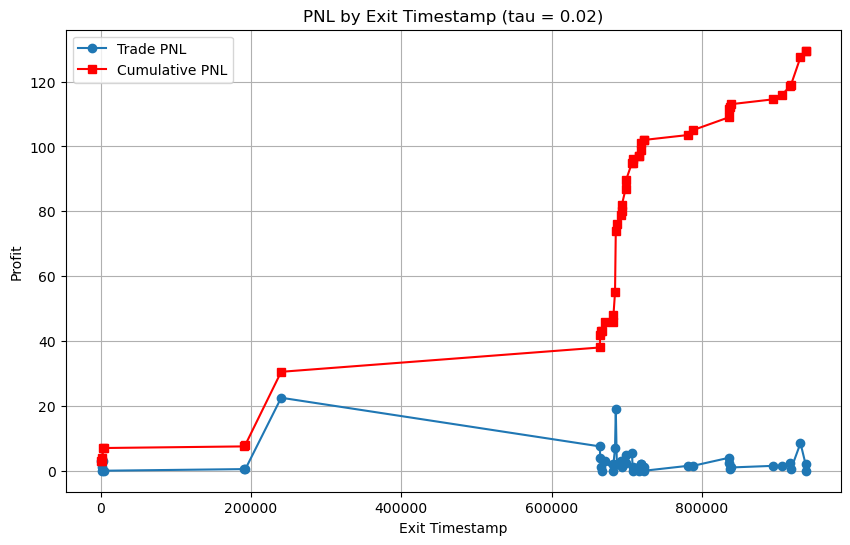

In [8]:
import pandas as pd
import numpy as np
import math
from scipy import stats, optimize
import matplotlib.pyplot as plt

# === Utility Functions ===

def bs_call_price(S, K, T, sigma, r=0.0):
    """
    Black-Scholes call option price (assumes zero risk-free rate).
    """
    d1 = (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * stats.norm.cdf(d1) - K * np.exp(-r * T) * stats.norm.cdf(d2)

def implied_vol(S, K, T, market_price, r=0.0):
    """
    Finds the implied volatility by solving the Black-Scholes equation.
    """
    def f(sigma):
        return bs_call_price(S, K, T, sigma, r) - market_price
    try:
        vol = optimize.brentq(f, 1e-6, 5.0)
    except Exception:
        vol = np.nan
    return vol

def bs_vega(S, K, T, sigma, r=0.0):
    """
    Computes the Black-Scholes vega.
    """
    d1 = (np.log(S / K) + 0.5 * sigma**2 * T) / (sigma * np.sqrt(T))
    return S * np.sqrt(T) * stats.norm.pdf(d1)

# === Data Loading and Preparation ===

# List of CSV files (adjust file paths as necessary)
files = [
    "prices_round_3_day_0.csv",
    "prices_round_3_day_1.csv",
    "prices_round_3_day_2.csv"
]

# Load CSV files using ';' as delimiter and tag each with a day indicator.
dfs = []
for i, file in enumerate(files):
    df = pd.read_csv(file, delimiter=';')
    df["day"] = i
    dfs.append(df)
data = pd.concat(dfs, ignore_index=True)

# --- Extract Underlying Price ---
# Rows where product == "VOLCANIC_ROCK" contain the underlying price (as mid_price).
underlying_df = data[data["product"] == "VOLCANIC_ROCK"][["day", "mid_price"]].rename(columns={"mid_price": "S"})
underlying_df = underlying_df.drop_duplicates(subset="day")

# --- Filter Voucher Data ---
# Voucher rows: products starting with "VOLCANIC_ROCK_VOUCHER"
voucher_data = data[data["product"].str.startswith("VOLCANIC_ROCK_VOUCHER")].copy()
voucher_data = voucher_data.merge(underlying_df, on="day", how="left")

# Define voucher strike prices (adjust if needed)
voucher_strikes = {
    "VOLCANIC_ROCK_VOUCHER_9500": 9500,
    "VOLCANIC_ROCK_VOUCHER_9750": 9750,
    "VOLCANIC_ROCK_VOUCHER_10000": 10000,
    "VOLCANIC_ROCK_VOUCHER_10250": 10250,
    "VOLCANIC_ROCK_VOUCHER_10500": 10500
}

# Assume Time-To-Expiry (TTE) is 5 days.
TTE = 5.0

# === Compute Metrics for Each Voucher ===
results = []
for idx, row in voucher_data.iterrows():
    product = row["product"]
    if product not in voucher_strikes:
        continue
    K = voucher_strikes[product]
    S = row["S"]               # underlying price (S) from merged data
    price = row["mid_price"]   # observed voucher price
    timestamp = row["timestamp"]
    day = row["day"]
    
    # Normalized moneyness: m = ln(K/S)/sqrt(TTE)
    m = np.log(K / S) / np.sqrt(TTE)
    
    # Compute implied volatility using the Black-Scholes inversion.
    iv = implied_vol(S, K, TTE, price, r=0)
    if np.isnan(iv):
        continue
    # Compute vega (for reference)
    vega = bs_vega(S, K, TTE, iv, r=0)
    
    results.append({
        "timestamp": timestamp,
        "day": day,
        "voucher": product,
        "K": K,
        "S": S,
        "price": price,
        "m": m,
        "iv": iv,
        "vega": vega
    })

res_df = pd.DataFrame(results)

# === Fit a Quadratic (Parabolic) Curve Per Day ===
# We assume the relationship: iv(m) = c2*m^2 + c1*m + c0.
# (The base IV is c0 = fitted iv at m=0.)
fitted_results = []
for day, day_df in res_df.groupby("day"):
    coeffs = np.polyfit(day_df["m"], day_df["iv"], 2)  # Coefficients: [c2, c1, c0]
    for idx, row in day_df.iterrows():
        m_val = row["m"]
        fitted_iv = coeffs[0] * (m_val**2) + coeffs[1] * m_val + coeffs[2]
        residual = row["iv"] - fitted_iv
        fitted_results.append({
            **row,
            "fitted_iv": fitted_iv,
            "residual": residual,
            "c2": coeffs[0],
            "c1": coeffs[1],
            "c0": coeffs[2]  # Base IV (at m = 0)
        })

fitted_df = pd.DataFrame(fitted_results)

# === Trading Strategy Simulation Using Actual Prices ===
# Trading rule:
#  - If |residual| > threshold tau on day d, enter a trade for that voucher.
#  - For a positive residual, the voucher appears overpriced so we short: 
#         Profit per unit = entry mid_price - exit mid_price.
#  - For a negative residual, the voucher appears underpriced so we go long: 
#         Profit per unit = exit mid_price - entry mid_price.
#  - We simulate trades from day d (entry) to day d+1 (exit) and record the corresponding timestamps.
tau = 0.02  # threshold for signaling a trade (adjustable)
trades = []

# For each voucher, sort observations by day (or timestamp) and simulate the trade.
for voucher, voucher_df in fitted_df.groupby("voucher"):
    voucher_df = voucher_df.sort_values("day").reset_index(drop=True)
    for i in range(len(voucher_df) - 1):
        entry = voucher_df.iloc[i]
        exit_ = voucher_df.iloc[i+1]
        # Check if the mispricing signal is strong enough.
        if abs(entry["residual"]) > tau:
            entry_price = entry["price"]  # mid price on entry day
            exit_price = exit_["price"]     # mid price on exit day
            # Record the timestamps from the original data.
            entry_timestamp = entry["timestamp"]
            exit_timestamp = exit_["timestamp"]
            
            # For an overpriced voucher (positive residual) we short, so profit = entry - exit.
            # For an underpriced voucher (negative residual) we go long, so profit = exit - entry.
            if entry["residual"] > 0:
                trade_profit = entry_price - exit_price
                direction = "short"
            else:
                trade_profit = exit_price - entry_price
                direction = "long"
            
            trades.append({
                "voucher": voucher,
                "entry_day": entry["day"],
                "exit_day": exit_["day"],
                "entry_timestamp": entry_timestamp,
                "exit_timestamp": exit_timestamp,
                "entry_price": entry_price,
                "exit_price": exit_price,
                "residual": entry["residual"],
                "direction": direction,
                "profit": trade_profit
            })

trades_df = pd.DataFrame(trades)

if trades_df.empty:
    print("No trades were generated under the chosen threshold.")
else:
    total_profit = trades_df["profit"].sum()
    num_trades = len(trades_df)
    avg_profit = total_profit / num_trades if num_trades > 0 else 0.0
    print(f"Total Profit: {total_profit:.2f}")
    print(f"Number of Trades: {num_trades}")
    print(f"Average Profit per Trade: {avg_profit:.2f}")
    print(trades_df)

    # === Plot PNL for each Exit Timestamp ===
    # First, convert exit_timestamp to a numeric or datetime type if necessary.
    # Here we assume exit_timestamp is numeric; if it's a string, use pd.to_datetime().
    pnl_by_timestamp = trades_df.groupby("exit_timestamp")["profit"].sum().sort_index()
    cumulative_pnl = pnl_by_timestamp.cumsum()
    
    plt.figure(figsize=(10, 6))
    plt.plot(pnl_by_timestamp.index, pnl_by_timestamp.values, marker='o', linestyle='-', label="Trade PNL")
    plt.plot(cumulative_pnl.index, cumulative_pnl.values, marker='s', linestyle='-', color='red', label="Cumulative PNL")
    plt.xlabel("Exit Timestamp")
    plt.ylabel("Profit")
    plt.title(f"PNL by Exit Timestamp (tau = {tau})")
    plt.legend()
    plt.grid(True)
    plt.show()


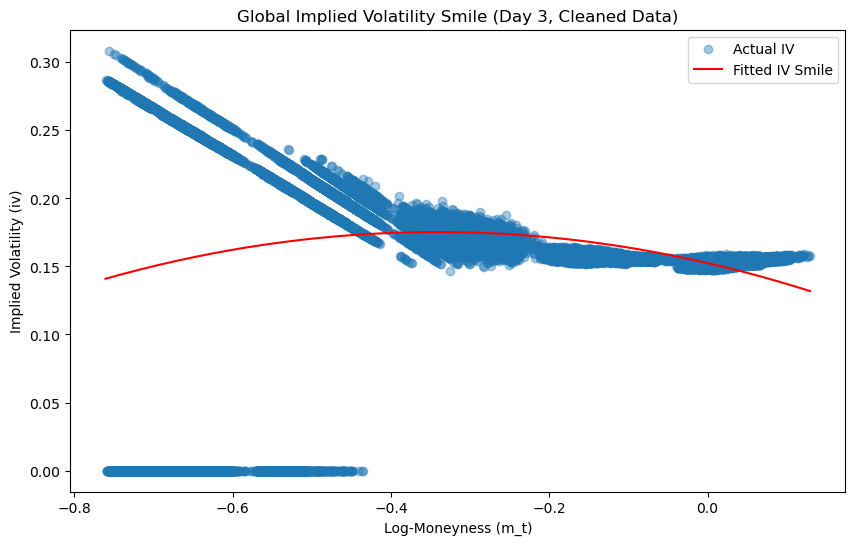

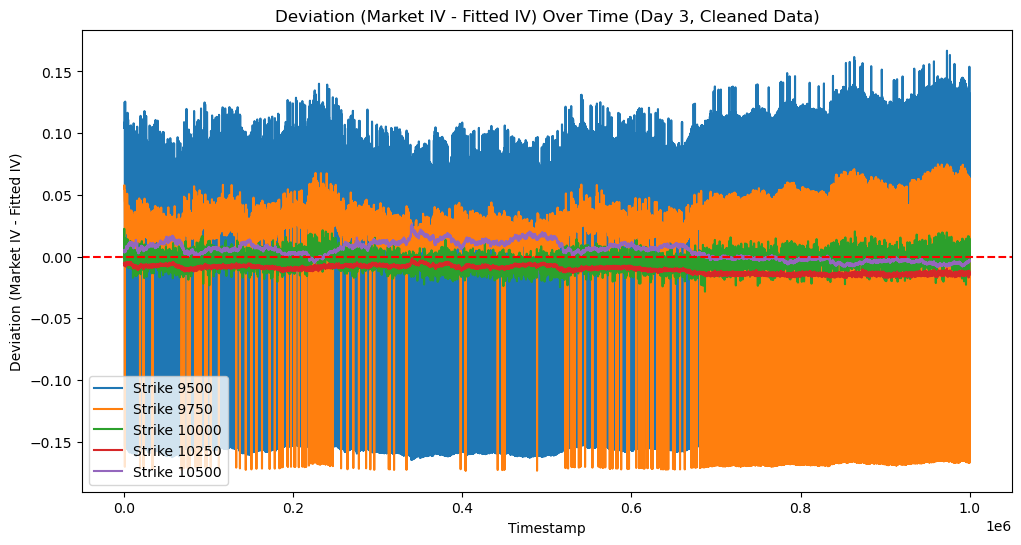

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

########################
# 1. Define Helper Functions
########################
def has_valid_quote(row):
    """Check if this row has valid (non-NaN, positive) bid/ask prices and volumes."""
    required_cols = ['bid_price_1', 'ask_price_1', 'bid_volume_1', 'ask_volume_1']
    # Ensure columns exist and are not NaN or zero
    for col in required_cols:
        if pd.isna(row[col]) or row[col] <= 0:
            return False
    return True

def black_scholes_call_price(S, K, T, sigma, r=0.0):
    if T <= 0:
        return max(S - K, 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def black_scholes_iv_solver_call(S, V, K, T, r=0.0, tol=1e-6, max_iter=100):
    """ Solve for implied volatility given call price V using Brent's method. """
    f = lambda sigma: black_scholes_call_price(S, K, T, sigma, r) - V
    intrinsic_value = max(S - K, 0)
    if V < intrinsic_value:
        return np.nan
    try:
        return brentq(f, 1e-6, 5.0, xtol=tol, maxiter=max_iter)
    except:
        return np.nan

def time_to_expiry(timestamp):
    """
    Example formula for day 3:
       TTE = ((8 - (timestamp // (3*1,000,000)))/365) - ((timestamp/1,000,000)/365)
    """
    day_index = timestamp // 3_000_000
    days_remaining = 8 - day_index
    fraction_of_day = timestamp / 1_000_000
    return (days_remaining / 365.0) - (fraction_of_day / 365.0)

########################
# 2. Load Data
########################
df = pd.read_csv("prices_round_3_day_0.csv", sep=';')

# Tag each row with valid quotes:
df['valid_quote'] = df.apply(has_valid_quote, axis=1)

# Separate underlying from vouchers, filtering only rows with valid quotes
underlying = df[
    (df['product'] == 'VOLCANIC_ROCK') & df['valid_quote']
].rename(columns={'mid_price': 'S_t'})
underlying = underlying[['timestamp', 'S_t']]

vouchers = df[
    df['product'].str.startswith("VOLCANIC_ROCK_VOUCHER_") & df['valid_quote']
].copy()

# Merge the underlying price into the voucher rows (only keep timestamps that appear in both)
vouchers = vouchers.merge(underlying, on='timestamp', how='inner')

########################
# 3. Compute IV and Moneyness
########################
records = []
for idx, row in vouchers.iterrows():
    product = row['product']
    # parse the strike
    strike_str = product.replace("VOLCANIC_ROCK_VOUCHER_", "")
    K = float(strike_str)
    S_t = row['S_t']
    V_t = row['mid_price']
    timestamp = row['timestamp']
    TTE = time_to_expiry(timestamp)
    day_val = row['day']

    if TTE <= 0 or pd.isna(S_t):
        continue

    iv = black_scholes_iv_solver_call(S_t, V_t, K, TTE)
    if pd.isna(iv):
        continue

    # log-moneyness
    m_t = np.log(K / S_t) / np.sqrt(TTE)

    records.append({
        'day': day_val,
        'timestamp': timestamp,
        'product': product,
        'strike': K,
        'S_t': S_t,
        'voucher_price': V_t,
        'TTE': TTE,
        'm_t': m_t,
        'iv': iv
    })

iv_df = pd.DataFrame(records)

########################
# 4. Fit the Parabolic Curve and Plot
########################
day3_data = iv_df[iv_df['day'] == 0].dropna(subset=['m_t', 'iv'])
if day3_data.empty:
    print("No valid data for day 3 after filtering out invalid quotes.")
else:
    # Fit polynomial
    coeffs = np.polyfit(day3_data['m_t'], day3_data['iv'], 2)
    p = np.poly1d(coeffs)

    # Plot the global smile
    m_vals = np.linspace(day3_data['m_t'].min(), day3_data['m_t'].max(), 200)
    fitted_ivs = p(m_vals)

    plt.figure(figsize=(10,6))
    plt.scatter(day3_data['m_t'], day3_data['iv'], alpha=0.4, label="Actual IV")
    plt.plot(m_vals, fitted_ivs, 'r', label="Fitted IV Smile")
    plt.xlabel("Log-Moneyness (m_t)")
    plt.ylabel("Implied Volatility (iv)")
    plt.title("Global Implied Volatility Smile (Day 3, Cleaned Data)")
    plt.legend()
    plt.show()

    # Deviation plot
    day3_data['iv_fitted'] = p(day3_data['m_t'])
    day3_data['deviation'] = day3_data['iv'] - day3_data['iv_fitted']

    plt.figure(figsize=(12,6))
    for strike in sorted(day3_data['strike'].unique()):
        subset = day3_data[day3_data['strike'] == strike]
        plt.plot(subset['timestamp'], subset['deviation'], label=f"Strike {int(strike)}")
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel("Timestamp")
    plt.ylabel("Deviation (Market IV - Fitted IV)")
    plt.title("Deviation (Market IV - Fitted IV) Over Time (Day 3, Cleaned Data)")
    plt.legend()
    plt.show()


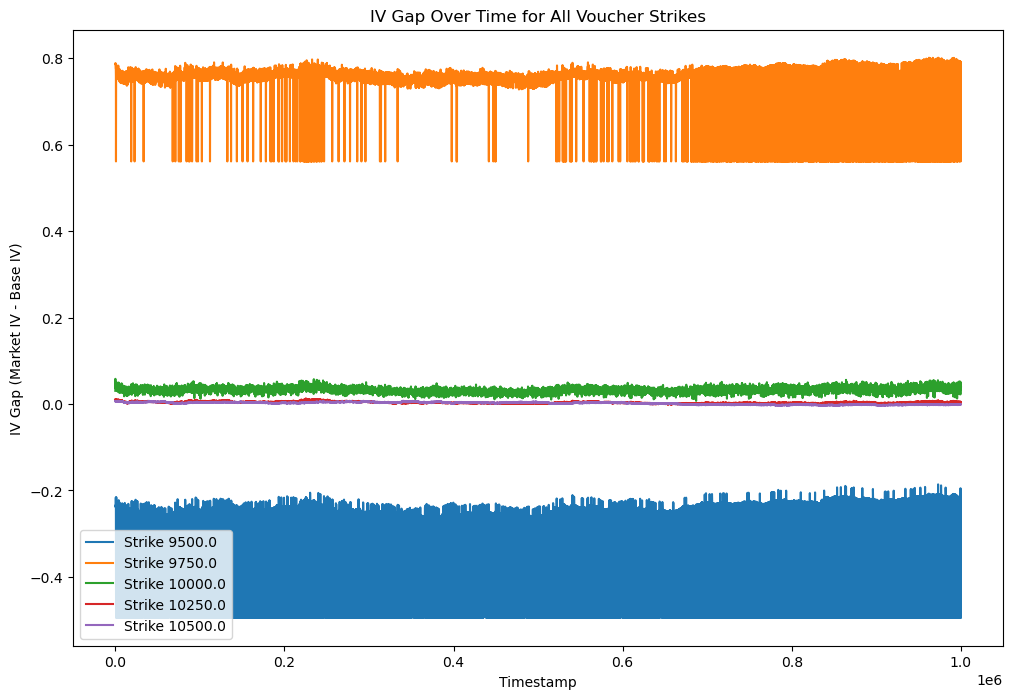

Optimized Parameters for Each Voucher:
    strike  optimal_tau_short  optimal_tau_long  optimal_tau_exit  \
0  10250.0           0.005772         -0.000965          0.004967   
1  10500.0           0.004104          0.000000          0.003574   

   total_profit  trade_count  avg_profit  
0         709.0          261    2.716475  
1         323.5          266    1.216165  


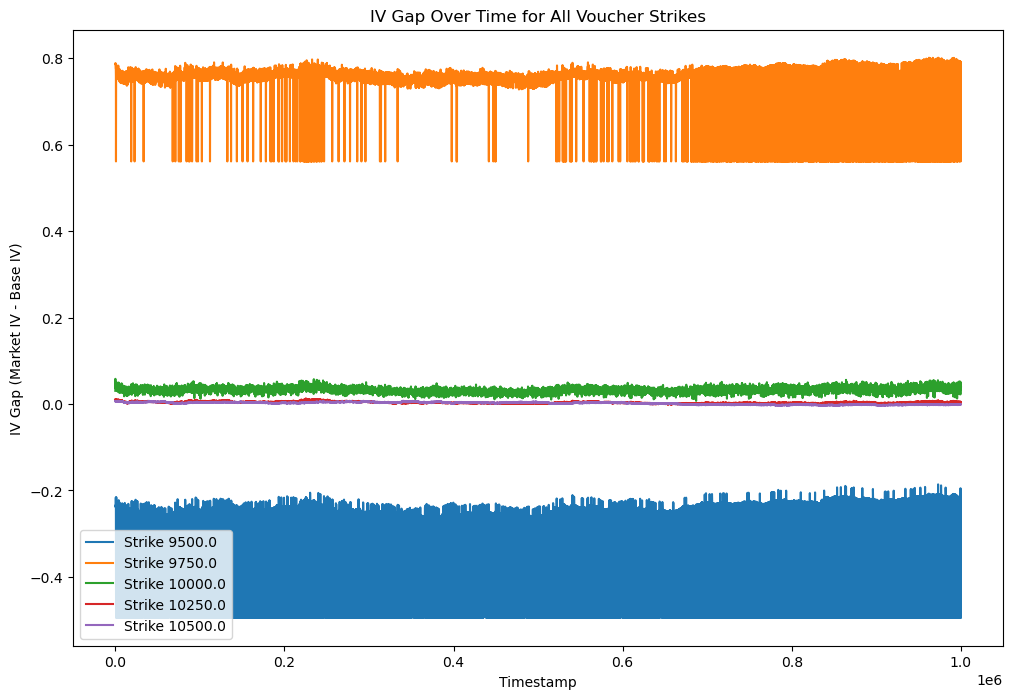

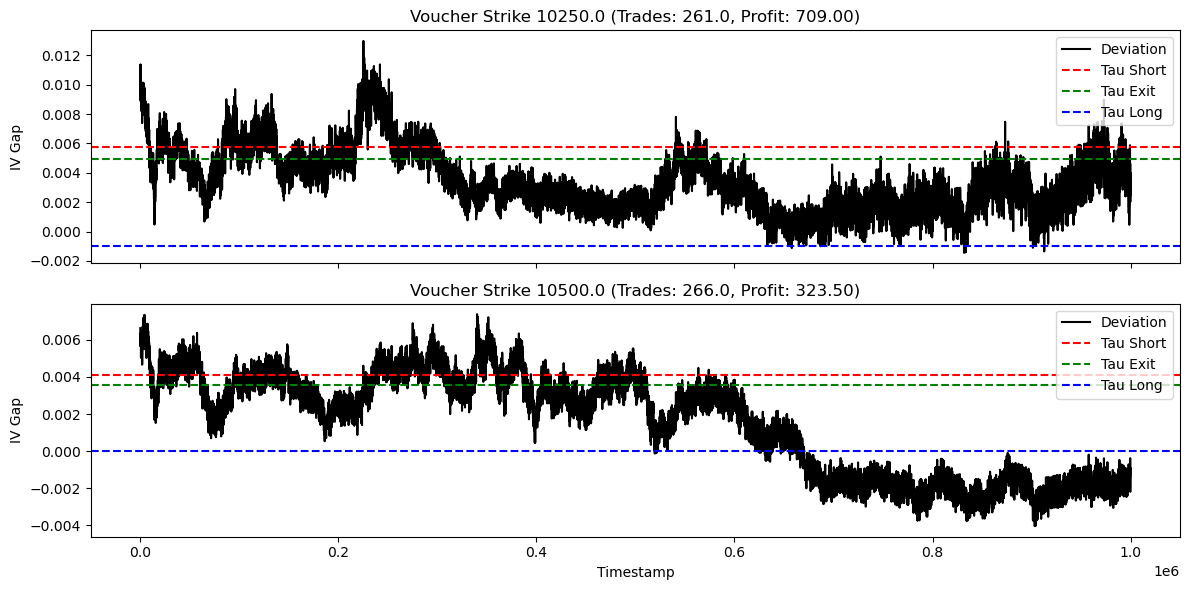

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------------------------------------------------
# 1. Recalculate IV Gaps (Deviation) Separately for Each Voucher
#
# For each voucher strike, fit a quadratic (parabolic) curve of iv vs m_t.
# The fitted base IV is taken as p(0), and for each row we compute:
#     deviation = iv - base_iv.
# --------------------------------------------------------------------
# Make a copy to avoid SettingWithCopyWarning:
day3_data = day3_data.copy()

# Process each voucher group separately
for strike, group in day3_data.groupby("strike"):
    # Drop any rows missing m_t or iv before fitting
    valid = group.dropna(subset=["m_t", "iv"])
    if valid.shape[0] < 3:
        # Not enough points to fit a quadratic; skip this group.
        continue
    coeffs = np.polyfit(valid["m_t"], valid["iv"], deg=2)
    p = np.poly1d(coeffs)
    base_iv = p(0)
    # Compute deviation = market iv - base_iv for the entire group.
    idx = group.index
    day3_data.loc[idx, "deviation"] = day3_data.loc[idx, "iv"] - base_iv

# --------------------------------------------------------------------
# 2. Plot the IV Gap Time Series for All Voucher Strikes
# --------------------------------------------------------------------
plt.figure(figsize=(12,8))
for strike, group in day3_data.groupby("strike"):
    plt.plot(group["timestamp"], group["deviation"], label=f"Strike {strike}")
plt.xlabel("Timestamp")
plt.ylabel("IV Gap (Market IV - Base IV)")
plt.title("IV Gap Over Time for All Voucher Strikes")
plt.legend()
plt.show()

# --------------------------------------------------------------------
# 3. Simulation Function Using Three Thresholds (No Hold Steps)
#
#  - When deviation > tau_short and no position, go SHORT.
#  - When deviation < tau_long and no position, go LONG.
#  - Exit the trade when the deviation reverts by crossing tau_exit.
#
# For LONG trades: profit = exit_price - entry_price.
# For SHORT trades: profit = entry_price - exit_price.
# --------------------------------------------------------------------
def simulate_trades_with_three_thresholds(df, tau_short, tau_long, tau_exit):
    """
    Simulate trades based on three thresholds (using the 'deviation' column).
    
    Parameters:
      df         : DataFrame for a single voucher (sorted by timestamp).
      tau_short  : Upper threshold. If deviation > tau_short and not in a trade, go SHORT.
      tau_long   : Lower threshold. If deviation < tau_long and not in a trade, go LONG.
      tau_exit   : Exit threshold. When in a long trade and deviation >= tau_exit OR
                   when in a short trade and deviation <= tau_exit, close the trade.
    
    Returns:
      total_profit : Total profit accumulated.
      trade_count  : Number of trades executed.
      avg_profit   : Average profit per trade.
    """
    # Ensure the data is sorted by timestamp.
    df = df.sort_values('timestamp').reset_index(drop=True)
    
    # Positions: 0 = no position; +1 = long; -1 = short.
    position = 0  
    entry_price = None
    pnl = []  # list for individual trade profit
    
    for i, row in df.iterrows():
        dev = row['deviation']
        price = row['voucher_price']
        
        # If not in a trade, decide on entry.
        if position == 0:
            if dev > tau_short:
                # Enter SHORT trade.
                position = -1
                entry_price = price
            elif dev < tau_long:
                # Enter LONG trade.
                position = +1
                entry_price = price
        else:
            # Check exit condition:
            # For LONG, exit when deviation >= tau_exit.
            # For SHORT, exit when deviation <= tau_exit.
            if (position == +1 and dev >= tau_exit) or (position == -1 and dev <= tau_exit):
                exit_price = price
                if position == +1:
                    trade_profit = exit_price - entry_price
                elif position == -1:
                    trade_profit = entry_price - exit_price
                pnl.append(trade_profit)
                position = 0
                entry_price = None
    # If still in an open trade at the end, close at the last price.
    if position != 0:
        exit_price = df.iloc[-1]['voucher_price']
        if position == +1:
            trade_profit = exit_price - entry_price
        else:
            trade_profit = entry_price - exit_price
        pnl.append(trade_profit)
    
    total_profit = np.sum(pnl)
    trade_count = len(pnl)
    avg_profit = np.mean(pnl) if trade_count > 0 else 0.0
    return total_profit, trade_count, avg_profit

# --------------------------------------------------------------------
# 4. Parameter Search over τ Thresholds for Each Voucher Strike
#
# For each voucher (grouped by strike) we search over:
#   - τ_short candidates (for short entry)
#   - τ_long candidates  (for long entry)
#   - τ_exit candidates  (for exiting a trade)
#
# We require that tau_long < tau_exit < tau_short.
# The grid search selects the candidate combination that maximizes total profit.
# --------------------------------------------------------------------
results = []
# Process each voucher group (for all 5 vouchers)
for strike, group in day3_data.groupby('strike'):
    group = group.sort_values('timestamp')
    min_dev = group['deviation'].min()
    max_dev = group['deviation'].max()
    
    # Only optimize if the group spans values on both sides of zero.
    if max_dev <= 0 or min_dev >= 0:
        continue
    
    # Candidate ranges:
    tau_short_candidates = np.linspace(0, max_dev, 10)
    tau_long_candidates  = np.linspace(min_dev, 0, 10)
    tau_exit_candidates  = np.linspace(min_dev, max_dev, 10)
    
    best_total_profit = -np.inf
    best_params = None
    
    # Grid search over all combinations that satisfy: tau_long < tau_exit < tau_short.
    for tau_short in tau_short_candidates:
        for tau_long in tau_long_candidates:
            for tau_exit in tau_exit_candidates:
                if not (tau_long < tau_exit < tau_short):
                    continue
                total_profit, trade_count, avg_profit = simulate_trades_with_three_thresholds(
                    group, tau_short, tau_long, tau_exit
                )
                if total_profit > best_total_profit:
                    best_total_profit = total_profit
                    best_params = (tau_short, tau_long, tau_exit, trade_count, avg_profit)
    
    if best_params is not None:
        results.append({
            'strike': strike,
            'optimal_tau_short': best_params[0],
            'optimal_tau_long': best_params[1],
            'optimal_tau_exit': best_params[2],
            'total_profit': best_total_profit,
            'trade_count': best_params[3],
            'avg_profit': best_params[4],
        })

results_df = pd.DataFrame(results)
print("Optimized Parameters for Each Voucher:")
print(results_df)

# --------------------------------------------------------------------
# 5. Plot IV Gap Time Series for All Vouchers with Their Optimal Thresholds
# --------------------------------------------------------------------
# Combined plot for all voucher strikes:
plt.figure(figsize=(12,8))
for strike, group in day3_data.groupby("strike"):
    plt.plot(group["timestamp"], group["deviation"], label=f"Strike {strike}")
plt.xlabel("Timestamp")
plt.ylabel("IV Gap (Market IV - Base IV)")
plt.title("IV Gap Over Time for All Voucher Strikes")
plt.legend()
plt.show()

# Additionally, for each voucher, plot deviation with its optimal thresholds:
num_strikes = len(results_df)
if num_strikes > 0:
    fig, ax_arr = plt.subplots(num_strikes, 1, figsize=(12, num_strikes * 3), sharex=True)
    # If there's only one plot, wrap it in a list.
    if num_strikes == 1:
        ax_arr = [ax_arr]
    # Use a different variable name (e.g., subplot_ax) to avoid conflicts.
    for subplot_ax, (_, row) in zip(ax_arr, results_df.iterrows()):
        strike = row['strike']
        group = day3_data[day3_data['strike'] == strike].sort_values('timestamp')
        subplot_ax.plot(group["timestamp"], group["deviation"], label="Deviation", color="black")
        subplot_ax.axhline(row['optimal_tau_short'], color='red', linestyle='--', label='Tau Short')
        subplot_ax.axhline(row['optimal_tau_exit'], color='green', linestyle='--', label='Tau Exit')
        subplot_ax.axhline(row['optimal_tau_long'], color='blue', linestyle='--', label='Tau Long')
        subplot_ax.set_title(f"Voucher Strike {strike} (Trades: {row['trade_count']}, Profit: {row['total_profit']:.2f})")
        subplot_ax.set_ylabel("IV Gap")
        subplot_ax.legend(loc="upper right")
    plt.xlabel("Timestamp")
    plt.tight_layout()
    plt.show()



Optimized Parameters for Each Voucher:
    strike  optimal_tau_short  optimal_tau_long  optimal_tau_exit  \
0  10250.0           0.004334         -0.000630          0.004205   
1  10500.0           0.002468         -0.001026          0.002061   

   total_profit  trade_count  avg_profit  
0         914.0          596    1.533557  
1         350.5          233    1.504292  


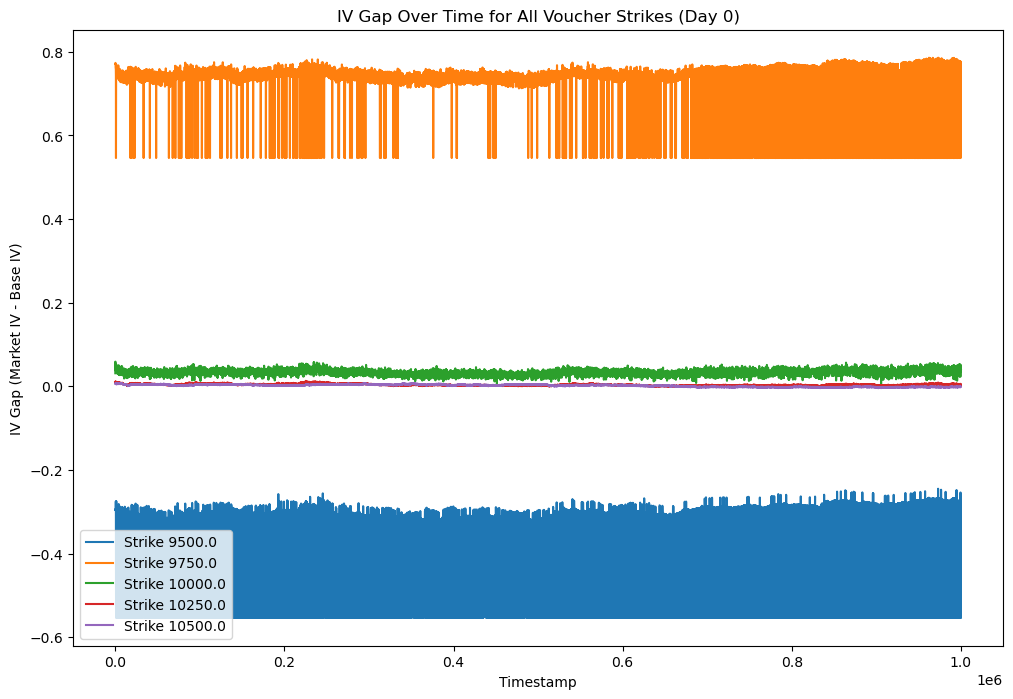

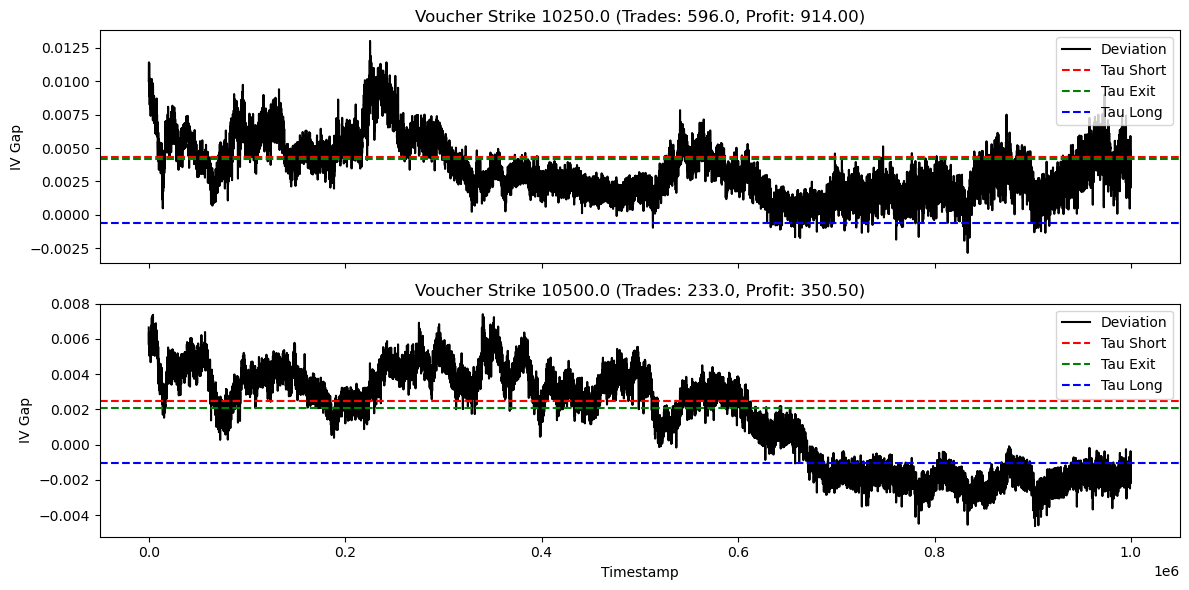

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import brentq

########################################################################
# 1. Define Utility Functions
########################################################################
def time_to_expiry_in_years(day, timestamp):
    """
    Computes the time-to-expiry (TTE) in years assuming:
      - 8 days until expiry at the very start of day 0
      - TTE decays linearly: at the end of day 0 (timestamp = 1e6), TTE = 7 days, etc.
    """
    TTE_days = 8 - (day + timestamp / 1e6)
    return TTE_days / 365.0

def black_scholes_call_price(S, K, T, sigma, r=0.0):
    """ Compute the Black–Scholes call price. """
    if T <= 0:
        return max(S - K, 0.0)
    d1 = (np.log(S/K) + (r + 0.5 * sigma**2)*T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K * np.exp(-r*T) * norm.cdf(d2)

def implied_vol_call_price(S, K, T, market_price, r=0.0):
    """
    Calculates the implied volatility for a call option using Brent's method.
    Returns NaN if the market price is less than intrinsic value.
    """
    intrinsic_val = max(S - K, 0)
    if market_price < intrinsic_val:
        return 0
    
    def f(sigma):
        return black_scholes_call_price(S, K, T, sigma, r) - market_price
    
    try:
        iv = brentq(f, 1e-6, 5.0, xtol=1e-6, maxiter=100)
        return iv
    except:
        return np.nan

########################################################################
# 2. Load and Transform Data
########################################################################
# Open the CSV file (adjust the filename/path as needed)
df = pd.read_csv("./prices_round_3_day_0.csv", sep=';')

# Extract the underlying instrument (assumed to be named "VOLCANIC_ROCK")
underlying = df[df['product'] == "VOLCANIC_ROCK"][["timestamp", "mid_price"]].copy()
underlying = underlying.rename(columns={'mid_price': 'S_t'})

# Extract the voucher data (products starting with "VOLCANIC_ROCK_VOUCHER_")
vouchers = df[df['product'].str.startswith("VOLCANIC_ROCK_VOUCHER_")].copy()

# Merge the underlying mid price into voucher rows by timestamp.
vouchers = pd.merge(vouchers, underlying, on="timestamp", how="left")

# Compute time-to-expiry (TTE) in years.
vouchers["TTE"] = vouchers.apply(lambda row: time_to_expiry_in_years(row['day'], row['timestamp']), axis=1)
vouchers = vouchers[(vouchers["TTE"] > 0) & (vouchers["S_t"] > 0)]

# Parse the strike price from the product name.
vouchers["strike"] = vouchers["product"].apply(lambda p: float(p.replace("VOLCANIC_ROCK_VOUCHER_", "")))
# Rename mid_price to voucher_price for clarity.
vouchers = vouchers.rename(columns={'mid_price': 'voucher_price'})

# Compute implied volatility for each voucher row.
def compute_iv(row):
    return implied_vol_call_price(row['S_t'], row['strike'], row['TTE'], row['voucher_price'])

vouchers["iv"] = vouchers.apply(compute_iv, axis=1)
# Compute log-moneyness: m_t = ln(K / S_t) / sqrt(TTE)
vouchers["m_t"] = vouchers.apply(lambda row: np.log(row["strike"] / row["S_t"]) / np.sqrt(row["TTE"]) if row["TTE"]>0 else np.nan, axis=1)

# Drop rows with missing values in required columns.
vouchers = vouchers.dropna(subset=["iv", "m_t"]).copy()
# We'll call this dataset 'day0_data' because we are on day 0.
day0_data = vouchers.copy()

########################################################################
# 3. For Each Voucher Strike, Fit a Quadratic Model (iv vs m_t) and Compute Deviation
########################################################################
day0_data["deviation"] = np.nan
for strike, group in day0_data.groupby("strike"):
    valid = group.dropna(subset=["m_t", "iv"])
    if len(valid) < 3:
        continue
    coeffs = np.polyfit(valid["m_t"], valid["iv"], deg=2)
    p = np.poly1d(coeffs)
    base_iv = p(0)
    indices = valid.index
    day0_data.loc[indices, "deviation"] = valid["iv"] - base_iv

########################################################################
# 4. Simulation Function for Trading Strategy with 3 Thresholds
########################################################################
def simulate_trades_with_three_thresholds(grp, tau_short, tau_long, tau_exit):
    """
    Simulate trades on a voucher group based on three thresholds (using the 'deviation' column):
      - If deviation > tau_short and no position, enter a SHORT trade.
      - If deviation < tau_long and no position, enter a LONG trade.
      - Exit an existing trade when the deviation reverts past tau_exit.
    
    For a LONG trade, profit = exit_price - entry_price.
    For a SHORT trade, profit = entry_price - exit_price.
    """
    grp = grp.sort_values("timestamp").reset_index(drop=True)
    position = 0  # 0 = no trade; +1 = long; -1 = short
    entry_price = None
    pnl = []
    
    for i, row in grp.iterrows():
        dev = row["deviation"]
        price = row["voucher_price"]
        if position == 0:
            if dev > tau_short:
                position = -1  # Enter SHORT trade.
                entry_price = price
            elif dev < tau_long:
                position = +1  # Enter LONG trade.
                entry_price = price
        else:
            # For LONG trade, exit when deviation >= tau_exit.
            # For SHORT trade, exit when deviation <= tau_exit.
            if (position == +1 and dev >= tau_exit) or (position == -1 and dev <= tau_exit):
                exit_price = price
                trade_profit = (exit_price - entry_price) if position == +1 else (entry_price - exit_price)
                pnl.append(trade_profit)
                position = 0
                entry_price = None
    
    # If still in a trade at the end, close at the last available price.
    if position != 0 and entry_price is not None:
        exit_price = grp.iloc[-1]["voucher_price"]
        trade_profit = (exit_price - entry_price) if position == +1 else (entry_price - exit_price)
        pnl.append(trade_profit)
    
    total_profit = np.sum(pnl)
    trade_count = len(pnl)
    avg_profit = np.mean(pnl) if trade_count > 0 else 0.0
    return total_profit, trade_count, avg_profit

########################################################################
# 5. Grid Search Over Thresholds for Each Voucher Strike
########################################################################
results = []
for strike, grp in day0_data.groupby("strike"):
    grp = grp.sort_values("timestamp")
    if grp["deviation"].isnull().all():
        continue
    d_min = grp["deviation"].min()
    d_max = grp["deviation"].max()
    # Only consider if the deviation spans values on both sides of zero.
    if d_max <= 0 or d_min >= 0:
        continue
    
    tau_short_candidates = np.linspace(0, d_max, 10)
    tau_long_candidates = np.linspace(d_min, 0, 10)
    tau_exit_candidates = np.linspace(d_min, d_max, 10)
    
    best_profit = -np.inf
    best_params = None
    
    for tau_s in tau_short_candidates:
        for tau_l in tau_long_candidates:
            for tau_x in tau_exit_candidates:
                if not (tau_l < tau_x < tau_s):
                    continue
                total_profit, trade_count, avg_profit = simulate_trades_with_three_thresholds(grp, tau_s, tau_l, tau_x)
                if total_profit > best_profit:
                    best_profit = total_profit
                    best_params = (tau_s, tau_l, tau_x, trade_count, avg_profit)
    
    if best_params is not None:
        results.append({
            "strike": strike,
            "optimal_tau_short": best_params[0],
            "optimal_tau_long": best_params[1],
            "optimal_tau_exit": best_params[2],
            "total_profit": best_profit,
            "trade_count": best_params[3],
            "avg_profit": best_params[4]
        })

results_df = pd.DataFrame(results)
print("Optimized Parameters for Each Voucher:")
print(results_df)

########################################################################
# 6. Plotting Results
########################################################################
# Combined plot: IV Gap over time for all voucher strikes.
plt.figure(figsize=(12,8))
for strike, grp in day0_data.groupby("strike"):
    plt.plot(grp["timestamp"], grp["deviation"], label=f"Strike {strike}")
plt.xlabel("Timestamp")
plt.ylabel("IV Gap (Market IV - Base IV)")
plt.title("IV Gap Over Time for All Voucher Strikes (Day 0)")
plt.legend()
plt.show()

# Individual subplots per strike showing the deviation and optimal thresholds.
num_strikes = len(results_df)
if num_strikes > 0:
    fig, ax_arr = plt.subplots(num_strikes, 1, figsize=(12, num_strikes * 3), sharex=True)
    if num_strikes == 1:
        ax_arr = [ax_arr]
    for subplot_ax, (_, row) in zip(ax_arr, results_df.iterrows()):
        strike = row["strike"]
        grp = day0_data[day0_data["strike"] == strike].sort_values("timestamp")
        subplot_ax.plot(grp["timestamp"], grp["deviation"], label="Deviation", color="black")
        subplot_ax.axhline(row["optimal_tau_short"], color='red', linestyle='--', label='Tau Short')
        subplot_ax.axhline(row["optimal_tau_exit"], color='green', linestyle='--', label='Tau Exit')
        subplot_ax.axhline(row["optimal_tau_long"], color='blue', linestyle='--', label='Tau Long')
        subplot_ax.set_title(f"Voucher Strike {strike} (Trades: {row['trade_count']}, Profit: {row['total_profit']:.2f})")
        subplot_ax.set_ylabel("IV Gap")
        subplot_ax.legend(loc="upper right")
    plt.xlabel("Timestamp")
    plt.tight_layout()
    plt.show()


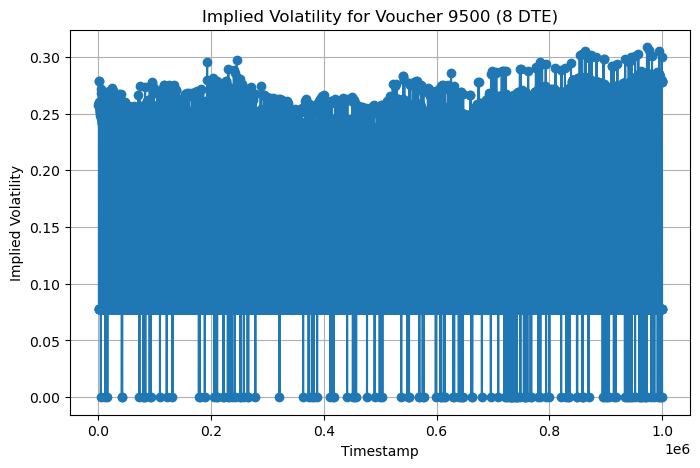

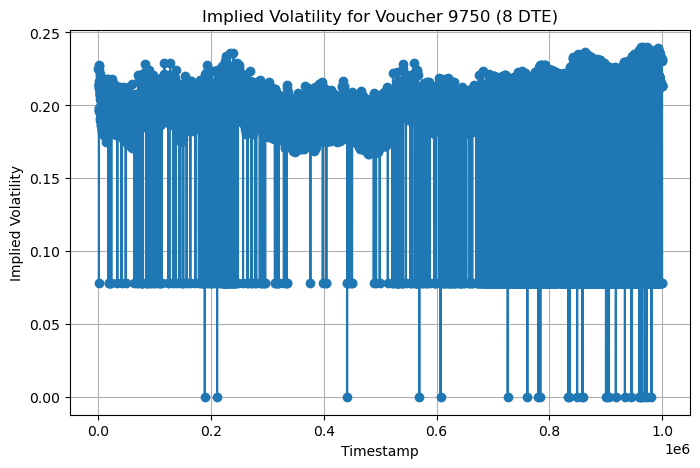

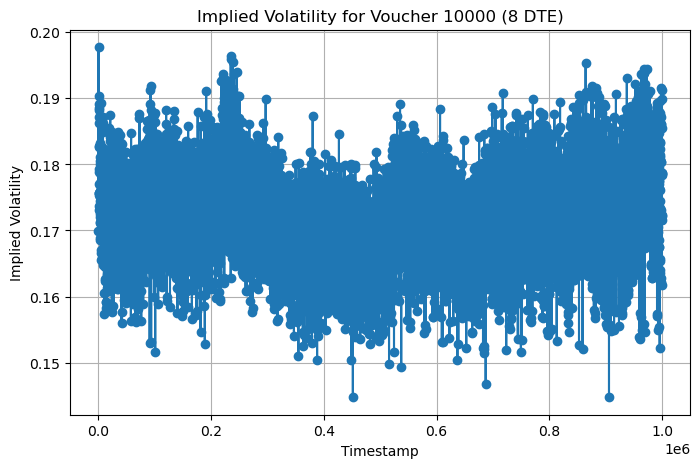

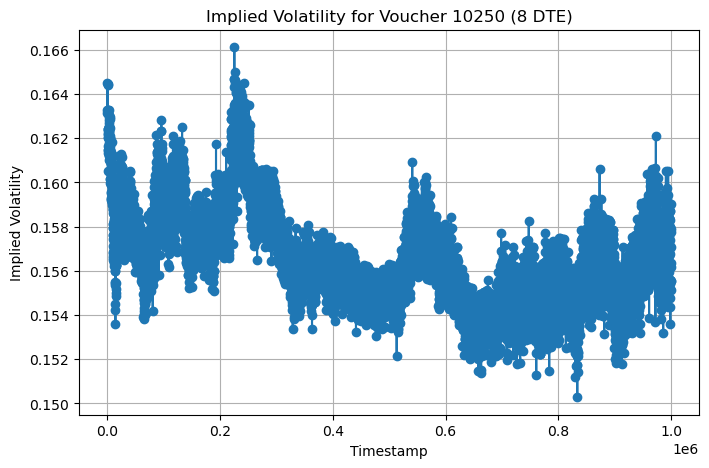

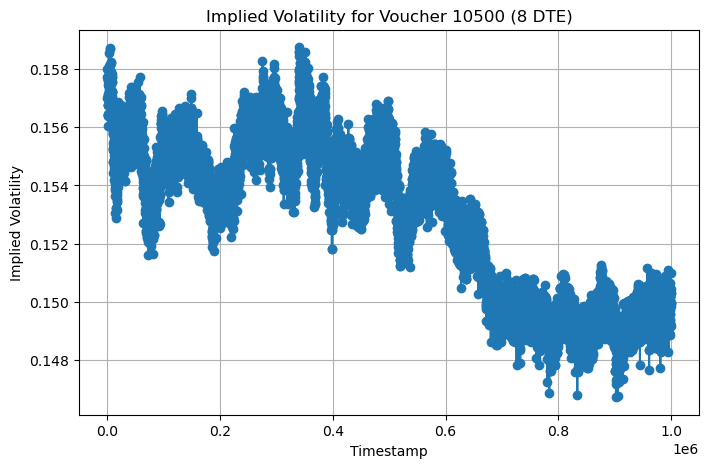

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Cumulative normal distribution function using the error function
def norm_cdf(x):
    return 0.5 * (1 + math.erf(x / math.sqrt(2)))

# Black-Scholes call price (with r = 0)
def black_call_price(S, K, T, sigma):
    if T <= 0:
        return max(0, S - K)
    d1 = (math.log(S/K) + 0.5 * sigma * sigma * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return S * norm_cdf(d1) - K * norm_cdf(d2)

# Bisection method to solve for implied volatility such that BS price matches market price
def implied_volatility(S, K, T, market_price, tol=1e-6, max_iter=100):
    low = 1e-6
    high = 5.0  # Adjust upper bound if needed
    for i in range(max_iter):
        mid = (low + high) / 2.0
        price = black_call_price(S, K, T, mid)
        if abs(price - market_price) < tol:
            return mid
        if price > market_price:
            high = mid
        else:
            low = mid
    return mid

# Load the CSV file (make sure the file is in the working directory)
df = pd.read_csv('prices_round_3_day_0.csv', delimiter=';')

# Define the voucher strikes we care about
voucher_strikes = [9500, 9750, 10000, 10250, 10500]

# Dictionary to store IV data for each voucher strike (timestamps and IV values)
iv_data = {strike: {'timestamp': [], 'iv': []} for strike in voucher_strikes}

# Group the data by timestamp so we handle each round separately.
for ts, group in df.groupby('timestamp'):
    # Get the underlying price from the "VOLCANIC_ROCK" product
    underlying_row = group[group['product'] == 'VOLCANIC_ROCK']
    if underlying_row.empty:
        continue
    S = underlying_row.iloc[0]['mid_price']
    
    # Compute time-to-expiry TTE.
    # Assuming CURRENT_ROUND=0 and EXPIRY_DAY=8:
    fractional_day = ts / 1_000_000  # Since timestamp is in [0, 1e6] on day 0
    days_to_expiry = 8 - fractional_day
    T = days_to_expiry / 365
    if T <= 0:
        continue

    # Process voucher rows in the current timestamp group
    for _, row in group.iterrows():
        prod = row['product']
        if prod.startswith("VOLCANIC_ROCK_VOUCHER_"):
            try:
                strike = int(prod.split('_')[-1])
            except ValueError:
                continue
            if strike in voucher_strikes:
                market_price = row['mid_price']
                iv = implied_volatility(S, strike, T, market_price)
                iv_data[strike]['timestamp'].append(ts)
                iv_data[strike]['iv'].append(iv)

# Now, plot each voucher's implied volatility on a separate graph.
for strike in voucher_strikes:
    data = iv_data[strike]
    if data['timestamp']:  # Only plot if there's data
        plt.figure(figsize=(8, 5))
        plt.plot(data['timestamp'], data['iv'], marker='o', linestyle='-')
        plt.xlabel('Timestamp')
        plt.ylabel('Implied Volatility')
        plt.title(f'Implied Volatility for Voucher {strike} (8 DTE)')
        plt.grid(True)
        plt.show()


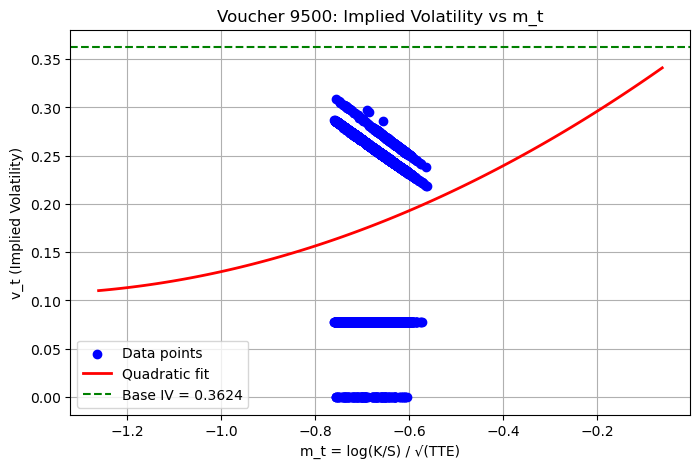

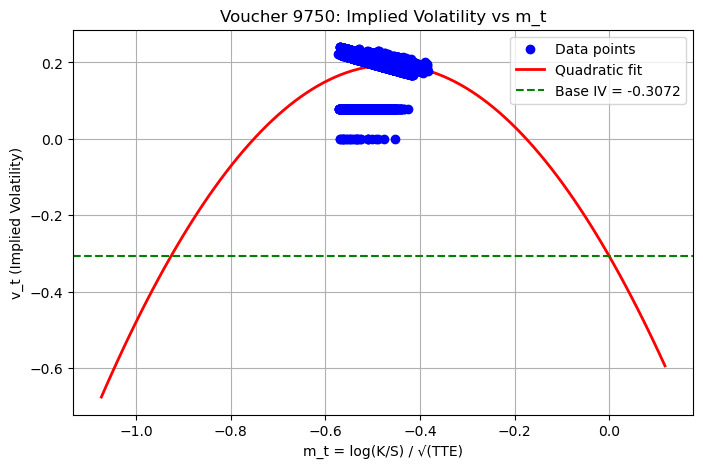

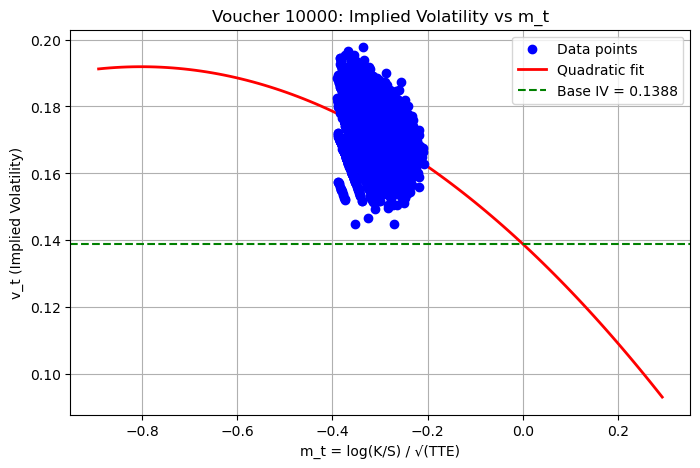

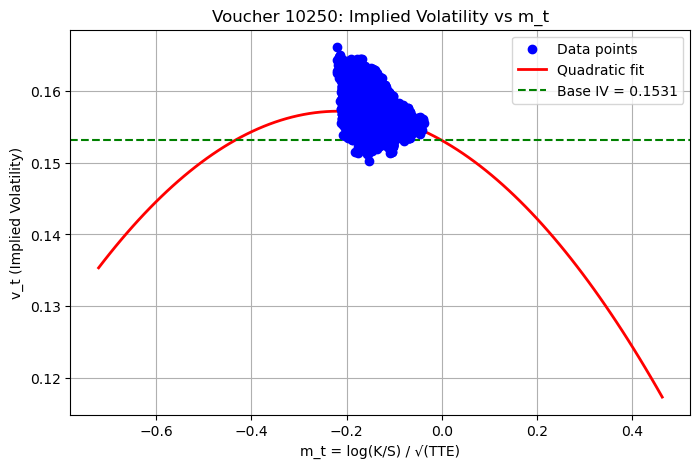

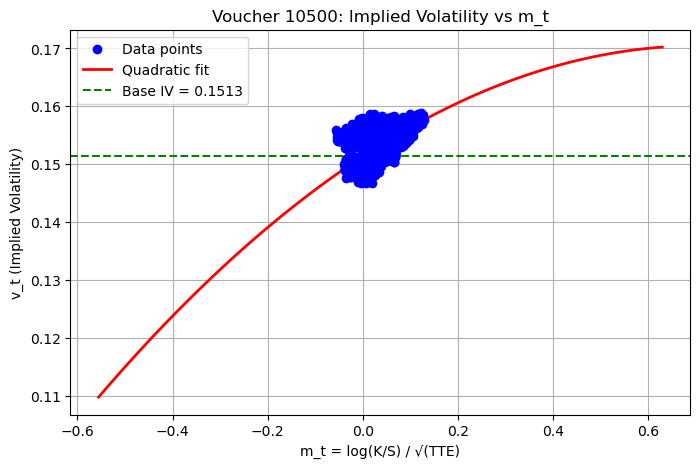

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# Cumulative normal distribution function using the error function
def norm_cdf(x):
    return 0.5 * (1 + math.erf(x / math.sqrt(2)))

# Black-Scholes call price with risk-free rate r = 0
def black_call_price(S, K, T, sigma):
    if T <= 0:
        return max(0, S - K)
    d1 = (math.log(S / K) + 0.5 * sigma * sigma * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return S * norm_cdf(d1) - K * norm_cdf(d2)

# Solve for implied volatility using a bisection method.
def implied_volatility(S, K, T, market_price, tol=1e-6, max_iter=100):
    low = 1e-6
    high = 5.0  # Adjust if needed.
    for i in range(max_iter):
        mid = (low + high) / 2.0
        price = black_call_price(S, K, T, mid)
        if abs(price - market_price) < tol:
            return mid
        if price > market_price:
            high = mid
        else:
            low = mid
    return mid

# Read the CSV file. (Ensure that prices_round_3_day_0.csv is in your working directory.)
df = pd.read_csv('prices_round_3_day_0.csv', delimiter=';')

# Define the voucher strikes we're interested in.
voucher_strikes = [9500, 9750, 10000, 10250, 10500]

# Prepare a dictionary to store data for each voucher:
# For each strike, we will store lists for timestamp, m_t, and v_t.
voucher_data = {strike: {'timestamp': [], 'm_t': [], 'v_t': []} for strike in voucher_strikes}

# Group data by timestamp since pricing, underlying price, and TTE vary with t.
for ts, group in df.groupby('timestamp'):
    # Extract the underlying price S from the "VOLCANIC_ROCK" row.
    underlying_row = group[group['product'] == 'VOLCANIC_ROCK']
    if underlying_row.empty:
        continue
    S = underlying_row.iloc[0]['mid_price']
    
    # Compute time-to-expiry (TTE). 
    # Here we assume: CURRENT_ROUND = 0 and EXPIRY_DAY = 8.
    # fractional_day = ts / 1,000,000 (since t ∈ [0,1e6] on day 0)
    fractional_day = ts / 1_000_000
    days_to_expiry = 8 - fractional_day
    TTE = days_to_expiry / 365.0
    if TTE <= 0:
        continue

    # Process every voucher row in this timestamp group.
    for _, row in group.iterrows():
        prod = row['product']
        if prod.startswith("VOLCANIC_ROCK_VOUCHER_"):
            try:
                strike = int(prod.split('_')[-1])
            except ValueError:
                continue
            if strike in voucher_strikes:
                market_price = row['mid_price']
                
                # Calculate m_t = log(K / S) / sqrt(TTE)
                m_t = math.log(strike / S) / math.sqrt(TTE)
                
                # Calculate v_t = implied volatility (using the Black-Scholes formula)
                v_t = implied_volatility(S, strike, TTE, market_price)
                
                voucher_data[strike]['timestamp'].append(ts)
                voucher_data[strike]['m_t'].append(m_t)
                voucher_data[strike]['v_t'].append(v_t)

# Now, for each voucher strike, fit a quadratic (parabolic) curve to (m_t, v_t) and plot the results separately.
for strike in voucher_strikes:
    data = voucher_data[strike]
    m_array = np.array(data['m_t'])
    v_array = np.array(data['v_t'])
    if len(m_array) == 0:
        continue
    
    # Fit a second-degree polynomial: v_t(m_t) = a*m_t^2 + b*m_t + c
    coeffs = np.polyfit(m_array, v_array, deg=2)
    poly = np.poly1d(coeffs)
    
    # Evaluate the polynomial on a range of m_t values for smooth curve plotting.
    m_fit = np.linspace(m_array.min() - 0.5, m_array.max() + 0.5, 100)
    v_fit = poly(m_fit)
    
    # The base IV is defined as the fitted value at m_t = 0.
    base_iv = poly(0)
    
    # Create a separate graph for this voucher.
    plt.figure(figsize=(8, 5))
    plt.scatter(m_array, v_array, color='blue', label='Data points', zorder=3)
    plt.plot(m_fit, v_fit, color='red', lw=2, label='Quadratic fit')
    plt.axhline(base_iv, color='green', linestyle='--', lw=1.5, label=f'Base IV = {base_iv:.4f}')
    plt.xlabel('m_t = log(K/S) / √(TTE)')
    plt.ylabel('v_t (Implied Volatility)')
    plt.title(f'Voucher {strike}: Implied Volatility vs m_t')
    plt.legend()
    plt.grid(True)
    plt.show()


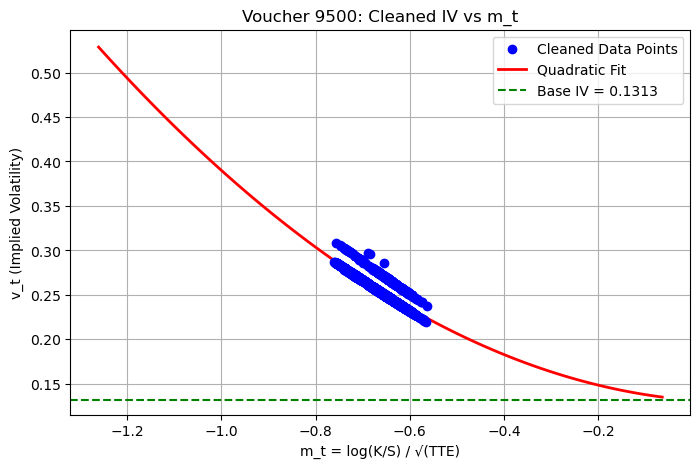

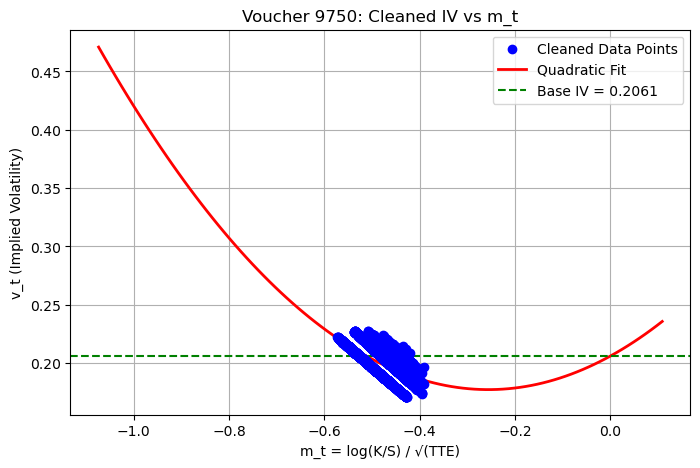

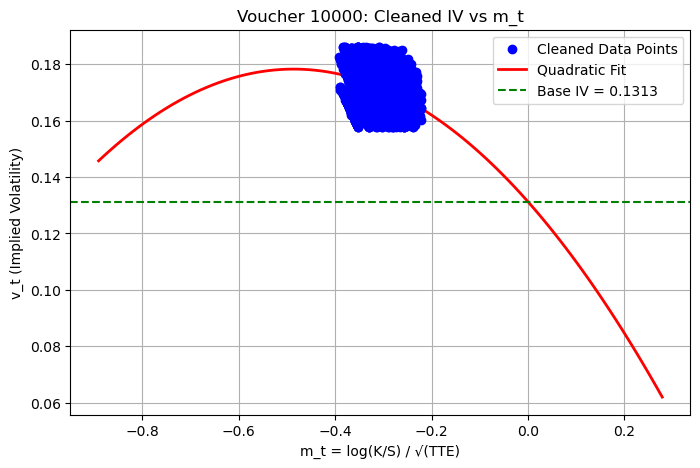

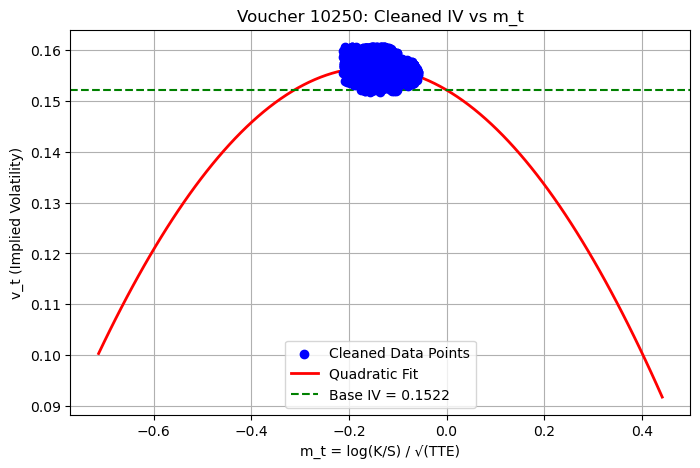

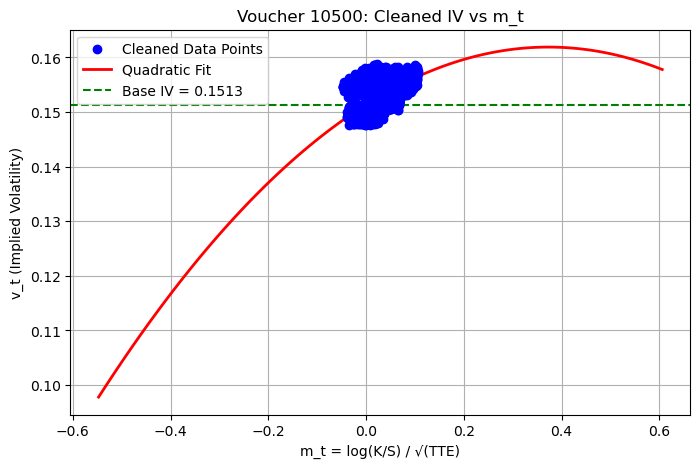

/var/folders/2l/smy92gh956l17wkm5_dsmlbr0000gn/T/ipykernel_12186/2380949126.py:58: RuntimeWarning: invalid value encountered in divide
  z_v = np.abs(v_vals - median_v) / mad_v


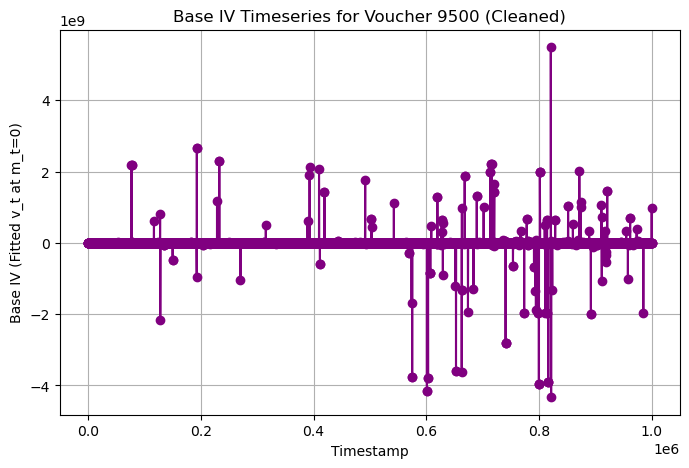

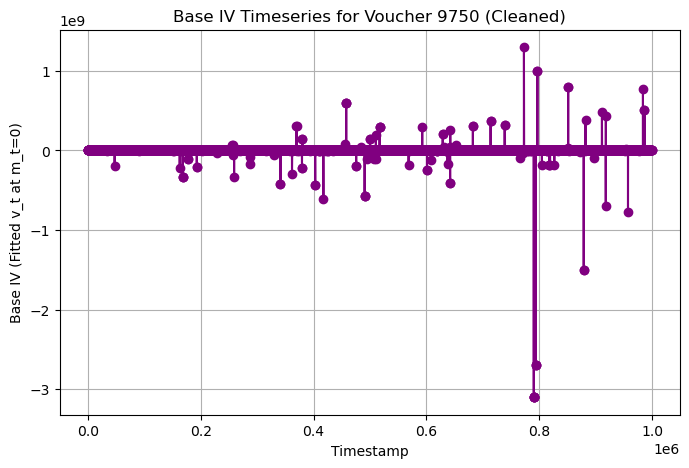

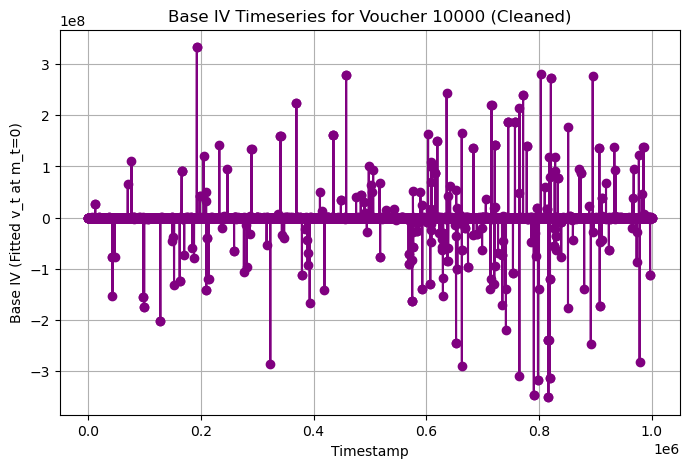

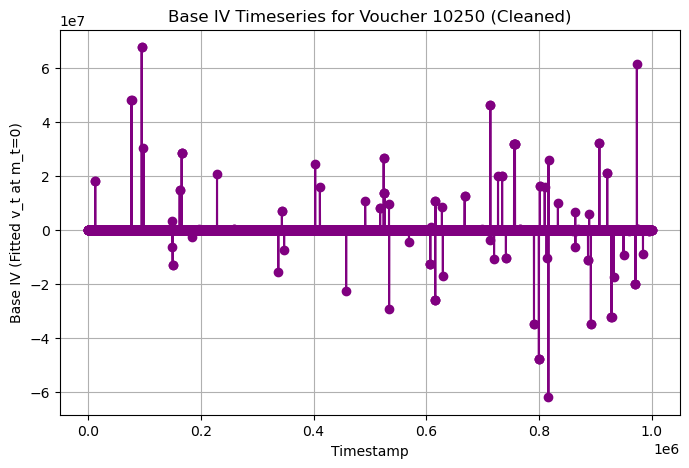

/var/folders/2l/smy92gh956l17wkm5_dsmlbr0000gn/T/ipykernel_12186/2380949126.py:180: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(window_m_clean, window_v_clean, deg=2)
/var/folders/2l/smy92gh956l17wkm5_dsmlbr0000gn/T/ipykernel_12186/2380949126.py:180: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(window_m_clean, window_v_clean, deg=2)
/Users/andriyluchko/anaconda3/lib/python3.12/site-packages/numpy/lib/polynomial.py:668: RuntimeWarning: invalid value encountered in divide
  lhs /= scale
/var/folders/2l/smy92gh956l17wkm5_dsmlbr0000gn/T/ipykernel_12186/2380949126.py:180: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(window_m_clean, window_v_clean, deg=2)


Skipping window starting at index 2471 due to singular matrix in polyfit.
Skipping window starting at index 2472 due to singular matrix in polyfit.
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
Skipping window starting at index 2473 due to singular matrix in polyfit.
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value


/var/folders/2l/smy92gh956l17wkm5_dsmlbr0000gn/T/ipykernel_12186/2380949126.py:180: RankWarning: Polyfit may be poorly conditioned
  coeffs = np.polyfit(window_m_clean, window_v_clean, deg=2)


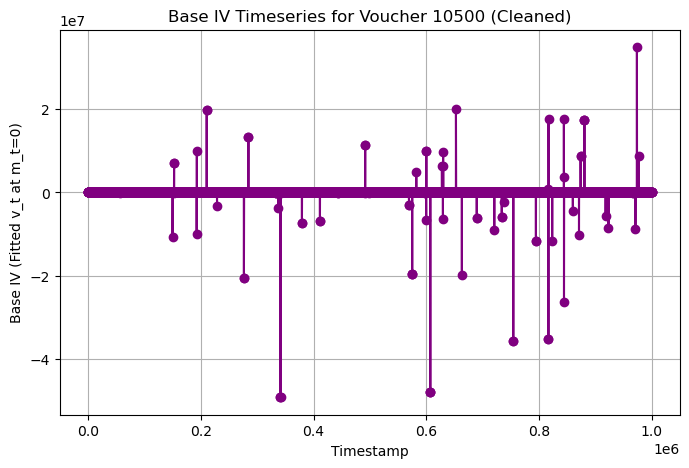

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

# -------------------------------
# Helper Functions
# -------------------------------

def norm_cdf(x):
    """Cumulative Normal Distribution using the error function."""
    return 0.5 * (1 + math.erf(x / math.sqrt(2)))

def black_call_price(S, K, T, sigma):
    """Black–Scholes call price with risk-free rate r = 0."""
    if T <= 0:
        return max(0, S - K)
    d1 = (math.log(S / K) + 0.5 * sigma * sigma * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return S * norm_cdf(d1) - K * norm_cdf(d2)

def implied_volatility(S, K, T, market_price, tol=1e-6, max_iter=100):
    """Solve for implied volatility using a bisection method."""
    low = 1e-6
    high = 5.0  # Adjust upper bound if necessary.
    for i in range(max_iter):
        mid = (low + high) / 2.0
        price = black_call_price(S, K, T, mid)
        if abs(price - market_price) < tol:
            return mid
        if price > market_price:
            high = mid
        else:
            low = mid
    return mid

def remove_outliers(m_vals, v_vals, threshold=3):
    """
    Remove outliers from paired data (m, v) using the Median Absolute Deviation (MAD).
    Returns only the points where both m and v are within the threshold.
    """
    m_vals = np.array(m_vals)
    v_vals = np.array(v_vals)
    
    median_m = np.median(m_vals)
    mad_m = np.median(np.abs(m_vals - median_m))
    median_v = np.median(v_vals)
    mad_v = np.median(np.abs(v_vals - median_v))
    
    # In case MAD is zero, fall back on standard deviation.
    if mad_m == 0:
        mad_m = np.std(m_vals)
    if mad_v == 0:
        mad_v = np.std(v_vals)
    
    # Compute robust z-scores
    z_m = np.abs(m_vals - median_m) / mad_m
    z_v = np.abs(v_vals - median_v) / mad_v
    mask = (z_m < threshold) & (z_v < threshold)
    return m_vals[mask], v_vals[mask]

# -------------------------------
# Data Processing
# -------------------------------

# Read the CSV file (ensure the file is in your working directory)
df = pd.read_csv('prices_round_3_day_0.csv', delimiter=';')

# Define the voucher strikes of interest.
voucher_strikes = [9500, 9750, 10000, 10250, 10500]

# Prepare a dictionary to store computed data for each voucher.
# For each voucher strike we collect lists of timestamps, m_t and v_t.
voucher_data = {strike: {'timestamp': [], 'm_t': [], 'v_t': []} for strike in voucher_strikes}

# Process the data by grouping rows by timestamp.
# Assumptions: CURRENT_ROUND = 0 and EXPIRY_DAY = 8.
for ts, group in df.groupby('timestamp'):
    # Extract the underlying asset's price from the "VOLCANIC_ROCK" row.
    underlying_row = group[group['product'] == 'VOLCANIC_ROCK']
    if underlying_row.empty:
        continue
    S = underlying_row.iloc[0]['mid_price']
    
    # Compute time-to-expiry:
    # fractional_day = ts / 1e6 (timestamps are in [0, 1e6] on day 0)
    fractional_day = ts / 1_000_000
    days_to_expiry = 8 - fractional_day
    TTE = days_to_expiry / 365.0
    if TTE <= 0:
        continue
    
    # Process voucher rows.
    for _, row in group.iterrows():
        prod = row['product']
        if prod.startswith("VOLCANIC_ROCK_VOUCHER_"):
            try:
                strike = int(prod.split('_')[-1])
            except ValueError:
                continue
            if strike in voucher_strikes:
                market_price = row['mid_price']
                # Compute m_t = log(K/S) / sqrt(TTE)
                m_t = math.log(strike / S) / math.sqrt(TTE)
                # Compute v_t as the implied volatility given market price.
                v_t = implied_volatility(S, strike, TTE, market_price)
                voucher_data[strike]['timestamp'].append(ts)
                voucher_data[strike]['m_t'].append(m_t)
                voucher_data[strike]['v_t'].append(v_t)

# -------------------------------
# Part 1: Plot v_t vs m_t with Quadratic Fit for Each Voucher (Cleaned Data)
# -------------------------------

for strike in voucher_strikes:
    data = voucher_data[strike]
    if not data['timestamp']:
        continue
    m_array = np.array(data['m_t'])
    v_array = np.array(data['v_t'])
    
    # Remove outliers using the helper function.
    m_clean, v_clean = remove_outliers(m_array, v_array, threshold=3)
    
    # Fit a quadratic model: v_t(m_t) = a * m_t^2 + b * m_t + c using the cleaned data.
    coeffs = np.polyfit(m_clean, v_clean, deg=2)
    poly = np.poly1d(coeffs)
    
    # Create a smooth curve for plotting.
    m_fit = np.linspace(m_clean.min() - 0.5, m_clean.max() + 0.5, 100)
    v_fit = poly(m_fit)
    
    # Compute base IV (fitted value at m_t = 0)
    base_iv_fit = poly(0)
    
    plt.figure(figsize=(8, 5))
    plt.scatter(m_clean, v_clean, color='blue', label='Cleaned Data Points', zorder=3)
    plt.plot(m_fit, v_fit, color='red', linewidth=2, label='Quadratic Fit')
    plt.axhline(base_iv_fit, color='green', linestyle='--', linewidth=1.5,
                label=f'Base IV = {base_iv_fit:.4f}')
    plt.xlabel('m_t = log(K/S) / √(TTE)')
    plt.ylabel('v_t (Implied Volatility)')
    plt.title(f'Voucher {strike}: Cleaned IV vs m_t')
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------------
# Part 2: Compute and Plot Base IV Timeseries via a Rolling Window (Cleaned Data)
# -------------------------------

rolling_window = 5  # Define the rolling window size (adjust as needed).

for strike in voucher_strikes:
    data = voucher_data[strike]
    timestamps = np.array(data['timestamp'])
    m_vals = np.array(data['m_t'])
    v_vals = np.array(data['v_t'])
    
    # Sort the data by timestamp.
    order = np.argsort(timestamps)
    timestamps = timestamps[order]
    m_vals = m_vals[order]
    v_vals = v_vals[order]
    
    base_iv_times = []
    base_iv_values = []
    
    # Use a rolling window over the sorted points.
    for i in range(len(timestamps) - rolling_window + 1):
        window_m = m_vals[i:i+rolling_window]
        window_v = v_vals[i:i+rolling_window]
        # Clean the data in the window to remove outliers.
        window_m_clean, window_v_clean = remove_outliers(window_m, window_v, threshold=3)
        # Proceed only if enough data points remain.
        if len(window_m_clean) < 3:
            continue
        try:
            # Fit the quadratic model within the window.
            coeffs = np.polyfit(window_m_clean, window_v_clean, deg=2)
            poly = np.poly1d(coeffs)
            base_iv = poly(0)  # Fitted base IV at m_t = 0.
        except np.linalg.LinAlgError:
            print(f"Skipping window starting at index {i} due to singular matrix in polyfit.")
            continue
        # Use the median timestamp of the window as the representative time.
        mid_ts = np.median(timestamps[i:i+rolling_window])
        base_iv_times.append(mid_ts)
        base_iv_values.append(base_iv)
    
    if base_iv_times:
        plt.figure(figsize=(8, 5))
        plt.plot(base_iv_times, base_iv_values, marker='o', linestyle='-', color='purple')
        plt.xlabel('Timestamp')
        plt.ylabel('Base IV (Fitted v_t at m_t=0)')
        plt.title(f'Base IV Timeseries for Voucher {strike} (Cleaned)')
        plt.grid(True)
        plt.show()


Voucher 9500: Fitted coefficients: [ 0.21257639 -0.04721574  0.12955311]
Voucher 9750: Fitted coefficients: [0.4812084  0.26620302 0.21649277]
Voucher 10000: Fitted coefficients: [-0.16939689 -0.17758198  0.1333646 ]
Voucher 10250: Fitted coefficients: [-0.18357126 -0.05765139  0.15209982]
Voucher 10500: Fitted coefficients: [-0.07720967  0.05670251  0.15134899]


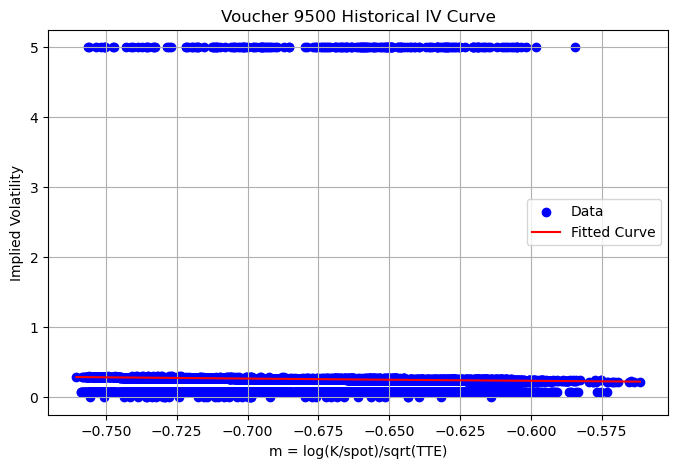

Voucher 9500: No valid parameters found.
Voucher 9750: No valid parameters found.
Voucher 10000: No valid parameters found.
Voucher 10250: No valid parameters found.
Voucher 10500: No valid parameters found.

Summary of Best Parameters:


In [ ]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Helper functions: CDF, pricing, implied volatility, and outlier removal.
# -------------------------------
def norm_cdf(x):
    return 0.5 * (1 + math.erf(x / math.sqrt(2)))

def black_call_price(S, K, T, sigma):
    if T <= 0:
        return max(0, S - K)
    d1 = (math.log(S/K) + 0.5 * sigma**2 * T) / (sigma * math.sqrt(T))
    d2 = d1 - sigma * math.sqrt(T)
    return S * norm_cdf(d1) - K * norm_cdf(d2)

def implied_volatility(S, K, T, market_price, tol=1e-6, max_iter=100):
    low, high = 1e-6, 5.0
    for _ in range(max_iter):
        mid = (low + high) / 2.0
        price = black_call_price(S, K, T, mid)
        if abs(price - market_price) < tol:
            return mid
        if price > market_price:
            high = mid
        else:
            low = mid
    return mid

def remove_outliers(m_vals, v_vals, threshold=3):
    m_vals = np.array(m_vals)
    v_vals = np.array(v_vals)
    median_m = np.median(m_vals)
    mad_m = np.median(np.abs(m_vals - median_m))
    median_v = np.median(v_vals)
    mad_v = np.median(np.abs(v_vals - median_v))
    if mad_m == 0:
        mad_m = np.std(m_vals)
    if mad_v == 0:
        mad_v = np.std(v_vals)
    z_m = np.abs(m_vals - median_m) / mad_m
    z_v = np.abs(v_vals - median_v) / mad_v
    mask = (z_m < threshold) & (z_v < threshold)
    return m_vals[mask], v_vals[mask]

# -------------------------------
# Step 1: Pre-fit the IV curve using historical data
# -------------------------------
df = pd.read_csv('prices_round_3_day_0.csv', delimiter=';')

voucher_strikes = [9500, 9750, 10000, 10250, 10500]
historical_data = {strike: {"m": [], "v": []} for strike in voucher_strikes}

# Assumptions: CURRENT_ROUND = 0 and EXPIRY_DAY = 8.
for ts, group in df.groupby('timestamp'):
    # Use the VOLCANIC_ROCK row for the underlying spot price
    rock_row = group[group['product'] == 'VOLCANIC_ROCK']
    if rock_row.empty:
        continue
    spot = rock_row.iloc[0]['mid_price']
    fractional_day = ts / 1_000_000
    days_to_expiry = 8 - fractional_day
    TTE = days_to_expiry / 365.0
    if TTE <= 0:
        continue
    for _, row in group.iterrows():
        prod = row['product']
        if prod.startswith("VOLCANIC_ROCK_VOUCHER_"):
            try:
                strike = int(prod.split('_')[-1])
            except ValueError:
                continue
            if strike in voucher_strikes:
                bid = row['bid_price_1']
                ask = row['ask_price_1']
                mid_price = (bid + ask) / 2
                m = math.log(strike / spot) / math.sqrt(TTE)
                v = implied_volatility(spot, strike, TTE, mid_price)
                if not math.isnan(v) and not math.isinf(v):
                    historical_data[strike]["m"].append(m)
                    historical_data[strike]["v"].append(v)

# Fit quadratic curves for each voucher.
fitted_curves = {}
for strike in voucher_strikes:
    m_arr = np.array(historical_data[strike]["m"])
    v_arr = np.array(historical_data[strike]["v"])
    if len(m_arr) < 3:
        print(f"Voucher {strike}: Not enough data for curve fit.")
        continue
    m_clean, v_clean = remove_outliers(m_arr, v_arr, threshold=3)
    coeffs = np.polyfit(m_clean, v_clean, deg=2)
    fitted_curves[strike] = coeffs
    print(f"Voucher {strike}: Fitted coefficients: {coeffs}")

# (Optional) Plot historical data and fitted curve for one voucher.
example_strike = voucher_strikes[0]
if example_strike in fitted_curves:
    coeffs = fitted_curves[example_strike]
    m_range = np.linspace(min(historical_data[example_strike]["m"]), max(historical_data[example_strike]["m"]), 100)
    fitted_v = np.polyval(coeffs, m_range)
    plt.figure(figsize=(8,5))
    plt.scatter(historical_data[example_strike]["m"], historical_data[example_strike]["v"], color='blue', label="Data")
    plt.plot(m_range, fitted_v, color='red', label="Fitted Curve")
    plt.xlabel("m = log(K/spot)/sqrt(TTE)")
    plt.ylabel("Implied Volatility")
    plt.title(f"Voucher {example_strike} Historical IV Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

# -------------------------------
# Step 2: Prepare data for backtesting using bid/ask and compute m and v
# -------------------------------
voucher_data_prefit = {strike: {"timestamp": [], "m_t": [], "v_t": [], "bid": [], "ask": []} for strike in voucher_strikes}

for ts, group in df.groupby('timestamp'):
    rock_row = group[group['product'] == 'VOLCANIC_ROCK']
    if rock_row.empty:
        continue
    spot = rock_row.iloc[0]['mid_price']
    fractional_day = ts / 1_000_000
    days_to_expiry = 8 - fractional_day
    TTE = days_to_expiry / 365.0
    if TTE <= 0:
        continue
    for _, row in group.iterrows():
        prod = row['product']
        if prod.startswith("VOLCANIC_ROCK_VOUCHER_"):
            try:
                strike = int(prod.split('_')[-1])
            except ValueError:
                continue
            if strike in voucher_strikes:
                bid = row['bid_price_1']
                ask = row['ask_price_1']
                mid_price = (bid + ask) / 2
                m = math.log(strike / spot) / math.sqrt(TTE)
                v = implied_volatility(spot, strike, TTE, mid_price)
                voucher_data_prefit[strike]["timestamp"].append(ts)
                voucher_data_prefit[strike]["m_t"].append(m)
                voucher_data_prefit[strike]["v_t"].append(v)
                voucher_data_prefit[strike]["bid"].append(bid)
                voucher_data_prefit[strike]["ask"].append(ask)

# -------------------------------
# Step 3: Updated Backtester with Pre-Fitted IV Curve and New Exit Threshold
# -------------------------------
def backtest_with_prefit_new(data, fitted_coeffs, long_tau, exit_tau, short_tau):
    """
    Backtest a mean-reversion strategy using a pre-computed IV curve.
    Instead of waiting for the signal to cross zero, exit when the signal enters [-exit_tau, +exit_tau].
    
    Execution: long positions (buy at ask, sell at bid) and short positions (sell at bid, buy at ask).
    
    Parameters:
        data: dictionary with arrays 'timestamp', 'm_t', 'v_t', 'bid', 'ask'.
        fitted_coeffs: (a, b, c) from historical quadratic regression.
        long_tau: Enter long if signal < -long_tau.
        exit_tau: Exit trade if signal is between -exit_tau and +exit_tau.
        short_tau: Enter short if signal > short_tau.
        
    Must satisfy: long_tau < exit_tau < short_tau.
    """
    ts = np.array(data['timestamp'])
    m_vals = np.array(data['m_t'])
    v_vals = np.array(data['v_t'])
    bid_prices = np.array(data['bid'])
    ask_prices = np.array(data['ask'])
    
    order_idx = np.argsort(ts)
    ts = ts[order_idx]
    m_vals = m_vals[order_idx]
    v_vals = v_vals[order_idx]
    bid_prices = bid_prices[order_idx]
    ask_prices = ask_prices[order_idx]
    
    position = 0  # 0: flat, +1: long, -1: short.
    entry_price = 0
    entry_ts = 0
    trades = []
    cumulative_pnl = 0
    pnl_time = []
    pnl_values = []
    
    a, b, c = fitted_coeffs
    
    for i in range(len(ts)):
        base_iv = a * m_vals[i]**2 + b * m_vals[i] + c
        current_bid = bid_prices[i]
        current_ask = ask_prices[i]
        current_iv = v_vals[i]  # Using pre-computed IV
        signal = current_iv - base_iv
        
        # Entry rules:
        if position == 0:
            if signal < -long_tau:
                position = 1
                entry_price = current_ask
                entry_ts = ts[i]
            elif signal > short_tau:
                position = -1
                entry_price = current_bid
                entry_ts = ts[i]
        else:
            # Exit rules:
            if position == 1 and signal >= -exit_tau:
                exit_price = current_bid  # exit long
                pnl = exit_price - entry_price
                cumulative_pnl += pnl
                trades.append((entry_ts, ts[i], 'long', entry_price, exit_price, pnl))
                position = 0
            elif position == -1 and signal <= exit_tau:
                exit_price = current_ask  # exit short
                pnl = entry_price - exit_price
                cumulative_pnl += pnl
                trades.append((entry_ts, ts[i], 'short', entry_price, exit_price, pnl))
                position = 0
        
        pnl_time.append(ts[i])
        pnl_values.append(cumulative_pnl)
    
    if position != 0:
        if position == 1:
            exit_price = bid_prices[-1]
            pnl = exit_price - entry_price
            trades.append((entry_ts, ts[-1], 'long', entry_price, exit_price, pnl))
        else:
            exit_price = ask_prices[-1]
            pnl = entry_price - exit_price
            trades.append((entry_ts, ts[-1], 'short', entry_price, exit_price, pnl))
        cumulative_pnl += pnl
        pnl_time.append(ts[-1])
        pnl_values.append(cumulative_pnl)
        
    return trades, pnl_time, pnl_values

# -------------------------------
# Step 4: Refined Grid Search Over Thresholds
# -------------------------------
# We'll use refined candidate ranges based on the signal distribution:
#   long_tau: from 0.001 to 0.04 (in increments of 0.002)
#   exit_tau: from 0.005 to 0.08 (in increments of 0.005)
#   short_tau: from 0.05 to 0.50 (in increments of 0.01)
long_candidates = np.arange(0.01, 0.2, 0.05)
exit_candidates = np.arange(0.01, 0.2, 0.05)
short_candidates = np.arange(0.001, 0.1, 0.01)

best_params = {}

for strike in voucher_strikes:
    data = voucher_data_prefit[strike]
    if len(data['timestamp']) < 3:
        print(f"Voucher {strike}: Not enough data for backtest.")
        continue
    best_pnl = -np.inf
    best_long = None
    best_exit = None
    best_short = None
    best_result = None
    for long_tau in long_candidates:
        for exit_tau in exit_candidates:
            for short_tau in short_candidates:
                if not (long_tau < exit_tau < short_tau):
                    continue
                trades, pnl_time, pnl_values = backtest_with_prefit_new(data, fitted_curves[strike], long_tau, exit_tau, short_tau)
                if len(pnl_values) == 0:
                    continue
                final_pnl = pnl_values[-1]
                if final_pnl > best_pnl:
                    best_pnl = final_pnl
                    best_long = long_tau
                    best_exit = exit_tau
                    best_short = short_tau
                    best_result = (trades, pnl_time, pnl_values)
    if best_long is None or best_exit is None or best_short is None:
        print(f"Voucher {strike}: No valid parameters found.")
        continue
    best_params[strike] = {
        'long_tau': best_long,
        'exit_tau': best_exit,
        'short_tau': best_short,
        'final_pnl': best_pnl,
        'result': best_result
    }
    print(f"Voucher {strike}: Best parameters: long_tau = {best_long:.3f}, exit_tau = {best_exit:.3f}, short_tau = {best_short:.3f}, Final PnL = {best_pnl:.4f}")
    trades, pnl_time, pnl_values = best_result
    for tr in trades:
        print(f"  Trade: {tr}")
    plt.figure(figsize=(8, 5))
    plt.plot(pnl_time, pnl_values, marker='o', linestyle='-')
    plt.xlabel("Timestamp")
    plt.ylabel("Cumulative PnL")
    plt.title(f"Voucher {strike} Best Params: (long_tau={best_long:.3f}, exit_tau={best_exit:.3f}, short_tau={best_short:.3f})\nFinal PnL = {best_pnl:.4f}")
    plt.grid(True)
    plt.show()

print("\nSummary of Best Parameters:")
for strike, params in best_params.items():
    print(f"Voucher {strike}: long_tau = {params['long_tau']:.3f}, exit_tau = {params['exit_tau']:.3f}, short_tau = {params['short_tau']:.3f}, Final PnL = {params['final_pnl']:.4f}")


Signal statistics for voucher 10000:
Min: -0.02642037575241346
Max: 4.8347373393927775
Mean: 0.10912688846604615
Std: 0.7175836297004187


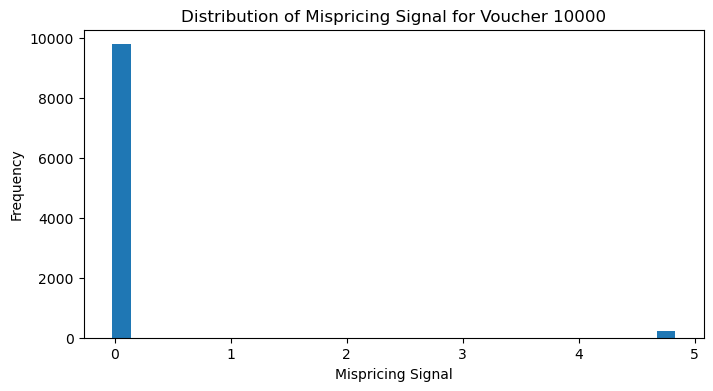

In [33]:
# Compute mispricing signals for one voucher
signals = []
for i in range(len(voucher_data_prefit[10000]["timestamp"])):
    m_val = voucher_data_prefit[10000]["m_t"][i]
    coeffs = fitted_curves[10000]
    base_iv = coeffs[0]*m_val**2 + coeffs[1]*m_val + coeffs[2]
    current_iv = voucher_data_prefit[10000]["v_t"][i]
    signals.append(current_iv - base_iv)

print("Signal statistics for voucher 10000:")
print("Min:", np.min(signals))
print("Max:", np.max(signals))
print("Mean:", np.mean(signals))
print("Std:", np.std(signals))

plt.figure(figsize=(8,4))
plt.hist(signals, bins=30)
plt.xlabel("Mispricing Signal")
plt.ylabel("Frequency")
plt.title("Distribution of Mispricing Signal for Voucher 10000")
plt.show()


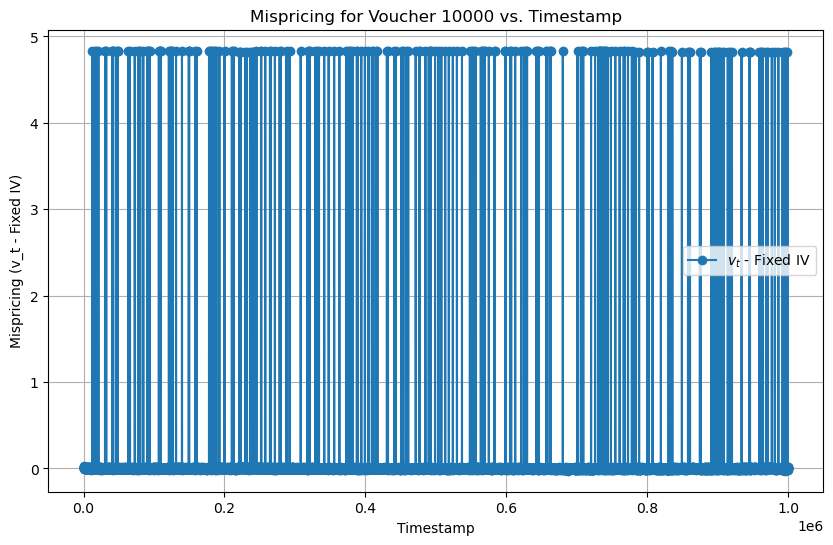

In [34]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

# (Assuming the functions implied_volatility and others have already been defined,
#  and that fitted_curves and voucher_data_prefit are computed as in your previous code.)

# Choose the voucher strike to plot. For example, voucher 10000.
voucher = 10000

# Check that the pre-fit curve exists and we have data for this voucher.
if voucher in fitted_curves and voucher in voucher_data_prefit:
    # Retrieve the fitted coefficients for this voucher
    coeffs = fitted_curves[voucher]  # These are the (a, b, c) coefficients from the quadratic fit.
    
    # Retrieve the tick-by-tick data for this voucher.
    ts = np.array(voucher_data_prefit[voucher]["timestamp"])
    m_vals = np.array(voucher_data_prefit[voucher]["m_t"])
    v_vals = np.array(voucher_data_prefit[voucher]["v_t"])
    
    # Compute the fixed IV from the quadratic regression for each tick:
    #   base_iv = a * m^2 + b * m + c
    base_iv_vals = np.polyval(coeffs, m_vals)
    
    # Compute the mispricing signal
    mispricing = v_vals - base_iv_vals
    
    # Plot the mispricing versus timestamp.
    plt.figure(figsize=(10, 6))
    plt.plot(ts, mispricing, 'o-', label="$v_t$ - Fixed IV")
    plt.xlabel("Timestamp")
    plt.ylabel("Mispricing (v_t - Fixed IV)")
    plt.title(f"Mispricing for Voucher {voucher} vs. Timestamp")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"No fitted data available for voucher {voucher}.")


Voucher 9500 with predefined parameters: long_tau = 0.008, exit_tau = 0.015, short_tau = 0.035
Final Cumulative PnL: nan
  Trade: (800, 1000, 'long', 998, 999.0, 1.0)
  Trade: (1400, 1600, 'long', 1011, 1004.0, -7.0)
  Trade: (1800, 2000, 'long', 998, 993.0, -5.0)
  Trade: (2100, 2400, 'long', 989, 986.0, -3.0)
  Trade: (2500, 2600, 'long', 981, 975.0, -6.0)
  Trade: (2800, 2900, 'long', 973, 973.0, 0.0)
  Trade: (3000, 3200, 'long', 979, 979.0, 0.0)
  Trade: (3300, 3400, 'long', 980, 980.0, 0.0)
  Trade: (3800, 3900, 'long', 984, 982.0, -2.0)
  Trade: (4200, 4300, 'short', nan, 966, nan)
  Trade: (4600, 4700, 'long', 952, 958.0, 6.0)
  Trade: (5800, 5900, 'long', 940, 931.0, -9.0)
  Trade: (6100, 6200, 'long', 941, 947.0, 6.0)
  Trade: (6400, 6600, 'long', 943, 940.0, -3.0)
  Trade: (6800, 6900, 'long', 933, 933.0, 0.0)
  Trade: (7000, 7100, 'long', 932, 935.0, 3.0)
  Trade: (7200, 7300, 'long', 939, 937.0, -2.0)
  Trade: (7900, 8000, 'long', 948, 943.0, -5.0)
  Trade: (8100, 8200, 'l

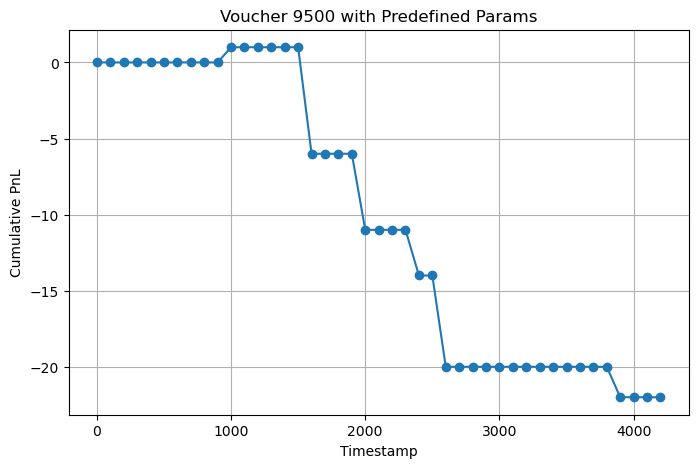

Voucher 9750 with predefined parameters: long_tau = 0.01, exit_tau = 0.02, short_tau = 0.045
Final Cumulative PnL: nan
  Trade: (800, 900, 'long', 748, 746.0, -2.0)
  Trade: (2900, 3000, 'long', 724, 729.0, 5.0)
  Trade: (4200, 4300, 'short', nan, 716, nan)
  Trade: (4500, 4600, 'long', 709, 702.0, -7.0)
  Trade: (4800, 4900, 'long', 715, 715.0, 0.0)
  Trade: (5100, 5200, 'long', 704, 706.0, 2.0)
  Trade: (5500, 5600, 'long', 692, 696.0, 4.0)
  Trade: (5700, 5800, 'long', 695, 690.0, -5.0)
  Trade: (6200, 6300, 'long', 698, 691.0, -7.0)
  Trade: (6600, 6700, 'long', 691, 676.0, -15.0)
  Trade: (6900, 7000, 'long', 684, 682.0, -2.0)
  Trade: (8200, 8300, 'long', 702, 691.0, -11.0)
  Trade: (8500, 8600, 'long', 698, 692.0, -6.0)
  Trade: (9000, 9100, 'long', 683, 674.0, -9.0)
  Trade: (9700, 9800, 'long', 677, 679.0, 2.0)
  Trade: (9900, 10000, 'long', 678, 670.0, -8.0)
  Trade: (10500, 10600, 'long', 678, 682.0, 4.0)
  Trade: (10800, 10900, 'long', 685, 689.0, 4.0)
  Trade: (11100, 1120

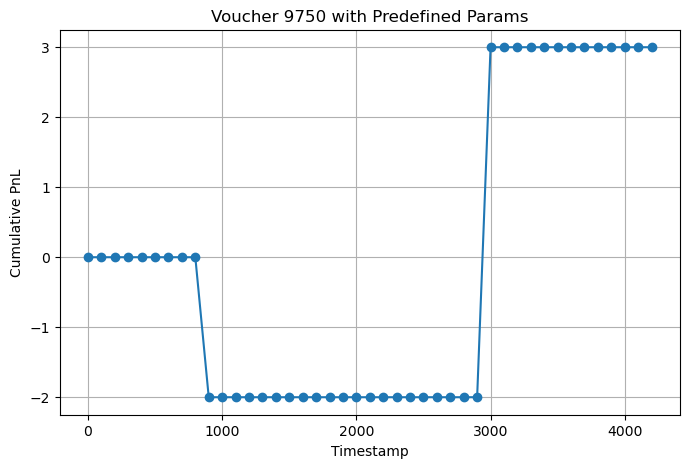

Voucher 10000 with predefined parameters: long_tau = 0.01, exit_tau = 0.02, short_tau = 0.04
Final Cumulative PnL: nan
  Trade: (10400, 10500, 'long', 429, 431.0, 2.0)
  Trade: (12200, 12300, 'short', nan, 440, nan)
  Trade: (12800, 12900, 'long', 435, 431.0, -4.0)
  Trade: (14700, 14800, 'long', 422, 416.0, -6.0)
  Trade: (15800, 15900, 'short', nan, 473, nan)
  Trade: (16500, 16600, 'long', 473, 473.0, 0.0)
  Trade: (17900, 18000, 'short', nan, 471, nan)
  Trade: (19500, 19600, 'long', 472, 471.0, -1.0)
  Trade: (21100, 21200, 'short', nan, 461, nan)
  Trade: (23600, 23700, 'long', 481, 485.0, 4.0)
  Trade: (26600, 26700, 'long', 464, 468.0, 4.0)
  Trade: (30500, 30700, 'short', nan, 431, nan)
  Trade: (32200, 32300, 'short', nan, 434, nan)
  Trade: (40900, 41000, 'short', nan, 443, nan)
  Trade: (41100, 41200, 'short', nan, 437, nan)
  Trade: (41400, 41500, 'short', nan, 444, nan)
  Trade: (41900, 42000, 'long', 429, nan, nan)
  Trade: (46000, 46100, 'long', 422, nan, nan)
  Trade: 

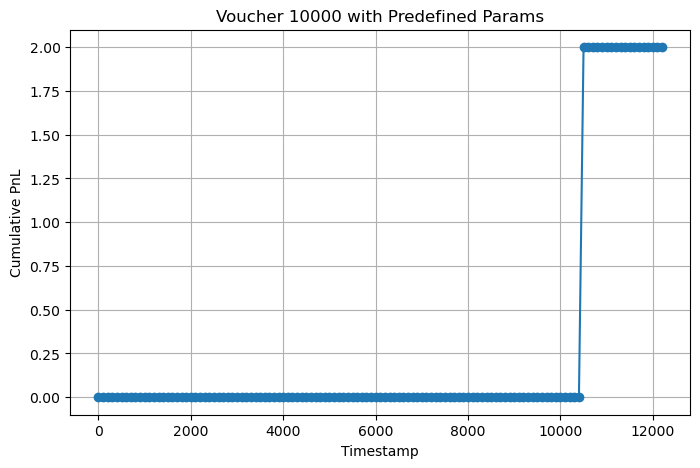

Voucher 10250 with predefined parameters: long_tau = 0.012, exit_tau = 0.025, short_tau = 0.06
Final Cumulative PnL: nan
  Trade: (4200, 4300, 'short', nan, 242, nan)
  Trade: (12200, 12300, 'short', nan, 215, nan)
  Trade: (15800, 15900, 'short', nan, 243, nan)
  Trade: (17900, 18000, 'short', nan, 242, nan)
  Trade: (21100, 21200, 'short', nan, 232, nan)
  Trade: (30500, 30700, 'short', nan, 209, nan)
  Trade: (32200, 32300, 'short', nan, 211, nan)
  Trade: (40900, 41000, 'short', nan, 219, nan)
  Trade: (41100, 41200, 'short', nan, 214, nan)
  Trade: (41400, 41500, 'short', nan, 219, nan)
  Trade: (42000, 42100, 'short', nan, 207, nan)
  Trade: (46100, 46200, 'short', nan, 202, nan)
  Trade: (48300, 48400, 'short', nan, 195, nan)
  Trade: (48600, 48700, 'short', nan, 191, nan)
  Trade: (63400, 63500, 'short', nan, 196, nan)
  Trade: (65900, 66000, 'short', nan, 183, nan)
  Trade: (72700, 72800, 'short', nan, 247, nan)
  Trade: (77500, 77600, 'short', nan, 246, nan)
  Trade: (78100, 

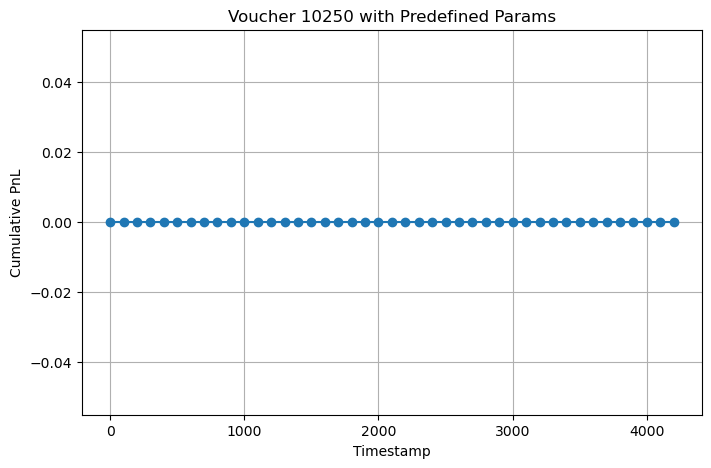

Voucher 10500 with predefined parameters: long_tau = 0.01, exit_tau = 0.02, short_tau = 0.05
Final Cumulative PnL: nan
  Trade: (4200, 4300, 'short', nan, 82, nan)
  Trade: (12200, 12300, 'short', nan, 67, nan)
  Trade: (15800, 15900, 'short', nan, 81, nan)
  Trade: (17900, 18000, 'short', nan, 80, nan)
  Trade: (21100, 21200, 'short', nan, 76, nan)
  Trade: (30500, 30700, 'short', nan, 64, nan)
  Trade: (32200, 32300, 'short', nan, 65, nan)
  Trade: (40900, 41000, 'short', nan, 69, nan)
  Trade: (41100, 41200, 'short', nan, 66, nan)
  Trade: (41400, 41500, 'short', nan, 69, nan)
  Trade: (42000, 42100, 'short', nan, 63, nan)
  Trade: (46100, 46200, 'short', nan, 61, nan)
  Trade: (48300, 48400, 'short', nan, 57, nan)
  Trade: (48600, 48700, 'short', nan, 55, nan)
  Trade: (63400, 63500, 'short', nan, 57, nan)
  Trade: (65900, 66000, 'short', nan, 51, nan)
  Trade: (72700, 72800, 'short', nan, 83, nan)
  Trade: (77500, 77600, 'short', nan, 82, nan)
  Trade: (78100, 78200, 'short', nan,

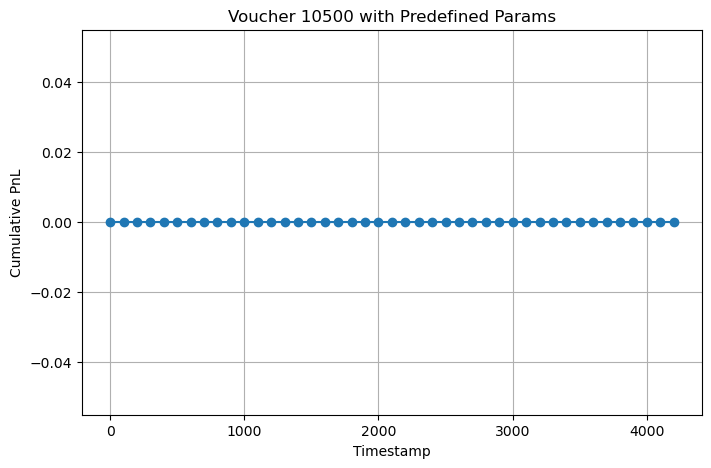

In [37]:
# For demonstration, using one set per voucher:
predefined_params = {
    9500: (0.008, 0.015, 0.035),
    9750: (0.010, 0.020, 0.045),
    10000: (0.010, 0.020, 0.040),
    10250: (0.012, 0.025, 0.060),
    10500: (0.010, 0.020, 0.050)
}

for strike in voucher_strikes:
    if strike not in fitted_curves:
        continue
    long_tau, exit_tau, short_tau = predefined_params[strike]
    trades, pnl_time, pnl_values = backtest_with_prefit_new(voucher_data_prefit[strike],
                                                             fitted_curves[strike],
                                                             long_tau, exit_tau, short_tau)
    print(f"Voucher {strike} with predefined parameters: long_tau = {long_tau}, exit_tau = {exit_tau}, short_tau = {short_tau}")
    print(f"Final Cumulative PnL: {pnl_values[-1] if pnl_values else 0}")
    for tr in trades:
        print(f"  Trade: {tr}")
    plt.figure(figsize=(8,5))
    plt.plot(pnl_time, pnl_values, marker='o', linestyle='-')
    plt.xlabel("Timestamp")
    plt.ylabel("Cumulative PnL")
    plt.title(f"Voucher {strike} with Predefined Params")
    plt.grid(True)
    plt.show()

In [38]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import differential_evolution

# (Assume all the helper functions are defined as above:
#  norm_cdf, black_call_price, implied_volatility, remove_outliers, etc.)
# Also assume that voucher_data_prefit and fitted_curves have been computed.

def backtest_with_prefit_new(data, fitted_coeffs, long_tau, exit_tau, short_tau):
    """
    Backtest a mean-reversion strategy using a pre-fitted IV curve and bid/ask prices.
    Exit the trade as soon as the mispricing (current IV minus fixed IV) is within [-exit_tau, +exit_tau].
    
    Parameters:
      data: dict with keys 'timestamp', 'm_t', 'v_t', 'bid', and 'ask'.
      fitted_coeffs: tuple (a, b, c) from historical quadratic regression.
      long_tau: entry threshold for long (enter long if signal < -long_tau).
      exit_tau: exit threshold (exit long if signal > -exit_tau, exit short if signal < exit_tau).
      short_tau: entry threshold for short (enter short if signal > short_tau).
      
    Returns:
      cumulative_pnl (final cumulative profit)
    """
    ts = np.array(data['timestamp'])
    m_vals = np.array(data['m_t'])
    v_vals = np.array(data['v_t'])
    bid_prices = np.array(data['bid'])
    ask_prices = np.array(data['ask'])
    
    order_idx = np.argsort(ts)
    ts = ts[order_idx]
    m_vals = m_vals[order_idx]
    v_vals = v_vals[order_idx]
    bid_prices = bid_prices[order_idx]
    ask_prices = ask_prices[order_idx]
    
    position = 0
    entry_price = 0
    cumulative_pnl = 0
    a, b, c = fitted_coeffs
    
    for i in range(len(ts)):
        base_iv = a * m_vals[i]**2 + b * m_vals[i] + c
        current_bid = bid_prices[i]
        current_ask = ask_prices[i]
        current_iv = v_vals[i]   # assuming v_vals are from data extraction
        signal = current_iv - base_iv
        
        if position == 0:
            if signal < -long_tau:
                position = 1
                entry_price = current_ask  # buy at ask
            elif signal > short_tau:
                position = -1
                entry_price = current_bid  # sell at bid
        else:
            if position == 1 and signal >= -exit_tau:
                exit_price = current_bid  # sell at bid for long
                cumulative_pnl += exit_price - entry_price
                position = 0
            elif position == -1 and signal <= exit_tau:
                exit_price = current_ask  # buy at ask for short
                cumulative_pnl += entry_price - exit_price
                position = 0
    # Close any open position at the end
    if position != 0:
        if position == 1:
            exit_price = bid_prices[-1]
            cumulative_pnl += exit_price - entry_price
        else:
            exit_price = ask_prices[-1]
            cumulative_pnl += entry_price - exit_price
    return cumulative_pnl

# Define an objective function for optimization.
def objective(params, data, fitted_coeffs):
    long_tau, exit_tau, short_tau = params
    # Ensure that long_tau < exit_tau < short_tau. If not, return a heavy penalty.
    if not (long_tau < exit_tau < short_tau):
        return 1e6
    pnl = backtest_with_prefit_new(data, fitted_coeffs, long_tau, exit_tau, short_tau)
    # We want to maximize pnl, so return -pnl since most optimizers minimize.
    return -pnl

# Let's choose one voucher to optimize, e.g., voucher 10000.
voucher = 10000
if voucher in voucher_data_prefit and voucher in fitted_curves:
    data = voucher_data_prefit[voucher]
    fitted_coeffs = fitted_curves[voucher]
    
    # Define bounds for the parameters:
    # long_tau: between 0.001 and 0.04; exit_tau: between 0.005 and 0.08; short_tau: between 0.05 and 0.50.
    bounds = [(0.001, 0.04), (0.005, 0.08), (0.05, 0.50)]
    
    # Use differential evolution to optimize.
    result = differential_evolution(objective, bounds, args=(data, fitted_coeffs), strategy='best1bin', disp=True, polish=True)
    
    best_params = result.x
    best_pnl = -result.fun
    print(f"Optimized parameters for voucher {voucher}: long_tau = {best_params[0]:.4f}, exit_tau = {best_params[1]:.4f}, short_tau = {best_params[2]:.4f}")
    print(f"Final Cumulative PnL: {best_pnl:.4f}")
else:
    print(f"Data for voucher {voucher} is not available.")


differential_evolution step 1: f(x)= nan
differential_evolution step 2: f(x)= nan
differential_evolution step 3: f(x)= nan
differential_evolution step 4: f(x)= nan
differential_evolution step 5: f(x)= nan
differential_evolution step 6: f(x)= nan
differential_evolution step 7: f(x)= nan
differential_evolution step 8: f(x)= nan
differential_evolution step 9: f(x)= nan
differential_evolution step 10: f(x)= nan
differential_evolution step 11: f(x)= nan
differential_evolution step 12: f(x)= nan
differential_evolution step 13: f(x)= nan
differential_evolution step 14: f(x)= nan
differential_evolution step 15: f(x)= nan
differential_evolution step 16: f(x)= nan
differential_evolution step 17: f(x)= nan
differential_evolution step 18: f(x)= nan
differential_evolution step 19: f(x)= nan
differential_evolution step 20: f(x)= nan
differential_evolution step 21: f(x)= nan
differential_evolution step 22: f(x)= nan
differential_evolution step 23: f(x)= nan
differential_evolution step 24: f(x)= nan
d